In [1]:
# ALLESFITTER #
from __future__ import print_function, division, absolute_import
import allesfitter
#::: plotting settings
import seaborn as sns
sns.set(context='paper', style='ticks', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_context(rc={'lines.markeredgewidth': 1})

#::: modules
import os, sys
import glob #to delete files and folders
from multiprocessing import cpu_count
if sys.version_info[0] == 3: # for Python3
    from tkinter import Tk, filedialog
elif sys.version_info[0] == 2: # for Python2
    from Tkinter import Tk
    import tkFileDialog as filedialog
import warnings
def custom_formatwarning(msg, *args, **kwargs):
    return str(msg) + '\n'
warnings.formatwarning = custom_formatwarning
    
#::: allesfitter modules
#::: somehow jupyter notebooks don't allow relative imports, so it needs a little hack...
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)
import allesfitter
from allesfitter.utils.latex_printer import round_txt_separately
from allesfitter.priors.transform_priors import get_cosi_from_i, get_Rsuma_from_a_over_Rstar, get_Rsuma_from_Rstar_over_a
from allesfitter.priors.estimate_noise import estimate_noise

%load_ext autoreload
%autoreload 2
#-----------------------------------------------------------#

import math
import numpy as np
from numpy.polynomial import Polynomial as Poly
from numpy.polynomial import Chebyshev as Cheb
import scipy
import scipy.stats as stats
import pandas as pd
from pandas import DataFrame
import os
import csv

import datetime
from datetime import date

from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.constants
from astropy.constants import R_sun, M_sun, R_jup,  M_jup, R_earth, au, G
from astropy.modeling import models, fitting

import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt
import matplotlib.gridspec as gridspec
import requests

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

import eleanor
#eleanor.Update()

import re
import pprint


! WARNING:
 The global colormaps dictionary is no longer considered public API.
type: <class 'matplotlib.cbook.deprecation.MatplotlibDeprecationWarning'>, file: /home/luke740/anaconda3/lib/python3.6/_collections_abc.py, line: 666


In [ ]:
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderC = 'Code Scripts/'
folderR = 'Results/'

## Construct Targetlist:
### NASA API Database and list of stale targets:

In [2]:
### TESTING ###
# PULLS DATA FROM NASA API TABLE = Exoplanets:
# ---------------------------------- #                                                                                                         HOST        NAME    RA DEC    T_0       -\delta T_0    +\delta T_0     P        -\delta P     +\delta P        e         -\delta e       +\delta e         a       -\delta a       +\delta a       i        -\delta i      +\delta i       M      -\delta M    +\delta M     R_p   -\delta R_p +\delta R_p   R_s                          depth    duration(D)            TTV                                             
api_url = 'https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets&select=pl_hostname,pl_name,ra,dec,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_massj,pl_massjerr1,pl_massjerr2,pl_radj,pl_radjerr1,pl_radjerr2,st_mass,st_masserr1,st_masserr2,st_rad,st_raderr1,st_raderr2,pl_trandep,pl_trandur,rowupdate,pl_ttvflag&order=pl_tranmid&where=pl_discmethod%20like%20%27%25Transit%25%27'
response = requests.get(api_url)
if response.status_code != 200:
    print('Failed to get data:', response.status_code)
else:
    data_API = pd.read_csv(api_url)
    NASA = DataFrame(data_API, columns=['pl_hostname', 'pl_name' , 'ra', 'dec', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbincl', 'pl_orbinclerr1' ,'pl_orbinclerr2', 'pl_massj', 'pl_massjerr1', 'pl_massjerr2', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_rad', 'st_raderr1', 'st_raderr2', 'pl_trandep', 'pl_trandur', 'rowupdate', 'pl_ttvflag'])
    #NASA = NASA[NASA['pl_tranmid'].notna()] #removes any target with no transit midpoint entry
    #df = df.fillna(0) # FILLS IN ALL NaN values with zeros"
print('Length of the NASA API database is', len(NASA))

Length of the NASA API database is 3347


In [3]:
NASA

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pl_hostname,pl_name,ra,dec,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,...,st_mass,st_masserr1,st_masserr2,st_rad,st_raderr1,st_raderr2,pl_trandep,pl_trandur,rowupdate,pl_ttvflag
pl_hostname,pl_name,ra,dec,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_massj,pl_massjerr1,pl_massjerr2,pl_radj,pl_radjerr1,pl_radjerr2,st_mass,st_masserr1,st_masserr2,st_rad,st_raderr1,st_raderr2,pl_trandep,pl_trandur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WASP-153,WASP-153 b,279.262390,40.018723,2453142.542000,0.003000,-0.003000,3.33260900,0.00000200,-0.00000200,0.009000,NaN,NaN,0.048000,0.001000,-0.001000,84.100,0.700,-0.700,0.39000,0.02000,-0.02000,1.550,0.100,-0.080,1.34,0.09,-0.09,1.73,0.10,-0.09,NaN,0.1600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K2-29,K2-29 b,62.670647,24.402042,2453219.009500,0.002200,-0.002200,3.25883210,0.00000190,-0.00000190,0.066000,0.022000,-0.022000,0.042170,0.000240,-0.000240,86.656,0.110,-0.080,0.73000,0.04000,-0.04000,1.190,0.020,-0.020,0.94,0.02,-0.02,0.86,0.01,-0.01,NaN,0.0925000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OGLE-TR-211,OGLE-TR-211 b,160.059951,-62.455601,2453428.334000,0.003000,-0.003000,3.67724000,0.00003000,-0.00003000,0.000000,NaN,NaN,0.051000,0.001000,-0.001000,87.200,NaN,NaN,1.03000,0.20000,-0.20000,1.360,0.180,-0.090,1.33,0.05,NaN,1.64,0.21,NaN,0.723000,0.1838000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lupus-TR-3,Lupus-TR-3 b,232.577571,-42.979908,2453887.081800,0.001300,-0.001300,3.91405000,0.00004000,-0.00004000,0.000000,NaN,NaN,0.046400,0.000700,-0.000700,88.300,1.300,-0.800,0.81000,0.18000,-0.18000,0.890,0.070,-0.070,0.87,0.04,NaN,0.82,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HAT-P-24,HAT-P-24 b,108.825058,14.262599,NaN,NaN,NaN,3.35524000,0.00000700,-0.00000700,0.070000,0.020000,-0.020000,NaN,NaN,NaN,88.600,0.700,-0.700,0.75000,0.25000,-0.25000,1.300,0.210,-0.210,1.37,0.69,-0.69,1.38,0.22,-0.22,0.940000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HAT-P-25,HAT-P-25 b,48.435419,25.197405,NaN,NaN,NaN,3.65281514,0.00000076,-0.00000075,0.023000,0.022000,-0.014000,0.046600,0.000810,-0.000800,88.220,0.450,-0.360,0.56900,0.02300,-0.02200,1.135,0.048,-0.048,1.01,0.05,-0.05,0.92,0.03,-0.03,0.016100,0.1172100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HAT-P-26,HAT-P-26 b,213.156383,4.059997,NaN,NaN,NaN,4.23452000,0.00001500,-0.00001500,0.120000,0.060000,-0.060000,NaN,NaN,NaN,88.600,0.700,-0.700,0.07000,0.02000,-0.02000,0.630,0.040,-0.040,1.12,0.36,-0.36,0.87,0.05,-0.05,0.540000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HAT-P-29,HAT-P-29 b,33.131142,51.778759,NaN,NaN,NaN,5.72319000,0.00004900,-0.00004900,0.090000,0.050000,-0.050000,NaN,NaN,NaN,87.100,0.600,-0.600,0.88000,0.25000,-0.25000,1.170,0.130,-0.130,1.45,0.60,-0.60,1.30,0.14,-0.14,0.860000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
NASA[0]

KeyError: 0

In [ ]:
# PULLS DATA FROM NASA API TABLE = Exoplanets:
# ---------------------------------- #                                                                                                         HOST        NAME    RA DEC    T_0       -\delta T_0    +\delta T_0     P        -\delta P     +\delta P        e         -\delta e       +\delta e         a       -\delta a       +\delta a       i        -\delta i      +\delta i       M      -\delta M    +\delta M     R_p   -\delta R_p +\delta R_p   R_s                          depth    duration(D)            TTV                                             
api_url = 'https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets&select=pl_hostname,pl_name,ra,dec,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_massj,pl_massjerr1,pl_massjerr2,pl_radj,pl_radjerr1,pl_radjerr2,st_mass,st_masserr1,st_masserr2,st_rad,st_raderr1,st_raderr2,pl_trandep,pl_trandur,rowupdate,pl_ttvflag&order=pl_tranmid&where=pl_discmethod%20like%20%27%25Transit%25%27'
response = requests.get(api_url)
if response.status_code != 200:
    print('Failed to get data:', response.status_code)
else:
    data_API = pd.read_csv(api_url)
    NASA = DataFrame(data_API, columns=['pl_hostname', 'pl_name' , 'ra', 'dec', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbincl', 'pl_orbinclerr1' ,'pl_orbinclerr2', 'pl_massj', 'pl_massjerr1', 'pl_massjerr2', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_rad', 'st_raderr1', 'st_raderr2', 'pl_trandep', 'pl_trandur', 'rowupdate', 'pl_ttvflag'])
    #NASA = NASA[NASA['pl_tranmid'].notna()] #removes any target with no transit midpoint entry
    #df = df.fillna(0) # FILLS IN ALL NaN values with zeros"
print('Length of the NASA API database is', len(NASA))

# LIST OF STALE TARGETS CALCULATED 21/10/2020 #
# ---------------------------------- #  
target_data = pd.read_csv(f'{directory+folderC}'+'stale_targets_3.csv')
#df_targets = DataFrame(target_data, columns=['ra', 'dec', 'pl_hostname', 'pl_name', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_orbper', 'pl_orbpererr1',	'pl_orbpererr2', 'pl_radj', 'st_rad', 'pl_eqt', 'pl_trandep', 'pl_trandur', 'rowupdate', 'pl_ttvflag', 'no_sectors', 'no_transits', 'semi_major', 'semi_major_err', 'eccentricity', 'eccentricity_err', 'inclination', 'inclination_err', 'long_per', 'long_per_err', 'radius', 'radius_err', 'TIC', 'Tmag', 'SNR'])
#df_targets = DataFrame(target_data, columns=['ra', 'dec', 'pl_hostname', 'pl_name', 'TIC', 'Tmag', 'SNR'])
df_targets = DataFrame(target_data, columns=['pl_hostname', 'pl_name', 'TIC', 'Tmag', 'SNR'])
print('Length of the targetlist is', len(df_targets))

Targetlist = NASA.merge(df_targets, how = 'inner', on = ['pl_hostname', 'pl_name'])
Targetlist = Targetlist.drop_duplicates(keep='first', inplace=False, ignore_index=True)
print('The targetlist has length', len(Targetlist))
Targetlist.to_csv('(2021-03-15)_Targetlist.csv')


### TESS web view tool sector information for each target

In [ ]:
# Sectors contains list of each sector and whether a target is observed or not #
# ---------------------------------- #
Sectors = pd.read_csv(f'{directory+folderC}'+'wtv-Stale_Targetlist_Coords_1.csv', delimiter=',', skiprows=61)
#print(len(Sectors))
T = []
O = []
for i in range(0, len(Sectors)):
    ### selects entire row (RA, DEC, S1 to SX) where X is the most recent sector number - 2
    j = np.array(Sectors.iloc[i,0:35])      
    ### replaces camera numbers with a 1 to enable sector counting
    j = np.where(j>0, 1, j)   
    ### removes RA and DEC values from the summation
    total = np.sum(j)-(j[0]+j[1]) 
    T.append(total)
    if total == 0:
        O.append(0)
    else:
        O.append(1)

Sectors['Observed'] = O
Sectors['#Sectors Observed'] = T
#print(len(T))

# Create a Mid-Targetlist containing API data and Sector data for each target #
# ---------------------------------- #
Mid_Targetlist = Targetlist.merge(Sectors, how = 'inner', on = ['ra', 'dec'])
Mid_Targetlist = Mid_Targetlist.drop_duplicates(keep='first', inplace=False, ignore_index=True)
Mid_Targetlist = Mid_Targetlist.fillna(0)
Mid_Targetlist.to_csv('(2021-03-15)_Mid_Targetlist.csv')


In [ ]:
Sectors

In [ ]:
Mid_Targetlist

### SNR re-calculation:
All data for a given target is on a single row in Mid_Targetlist.
As such, by iterating over each row, an SNR value can be calculated.

In [ ]:
# Reconstructed Noise Function #
# ---------------------------------- #
def TESS_NOISE_v2(x):
    read = 10**(x*0.35055351) * 10**(-1.89114391)
    stellar = 10**(0.21560338*x) * 10**(0.09797272)
    sky = 10**(0.3565365*x) * 10**(-1.8803056)
    return np.sqrt(read**2 + stellar**2 + sky**2 + 60**2)

TESS_Noise = []
for i in range(0, len(Mid_Targetlist)):
    Tmag = Mid_Targetlist['Tmag'][i]
    if Tmag == 'Not Found':
        TESS_Noise.append(np.inf)
    elif Tmag == 'not found':
        TESS_Noise.append(np.inf)
    else: 
        TESS_Noise.append(TESS_NOISE_v2(float(Tmag)))
print(len(TESS_Noise))
Mid_Targetlist.insert(37, 'TESS Noise', TESS_Noise, False)


NEW_SNR = []
print(len(Mid_Targetlist))
for i in range(0, len(Mid_Targetlist)):
    Name = Mid_Targetlist['pl_name'][i]
    R_p = Mid_Targetlist['pl_radj'][i]*R_jup # R_p in m
    R_s = Mid_Targetlist['st_rad'][i]*R_sun # R_s in m
    DEPTH_ppm = ((R_p/R_s)**2) * 1000000
                # depth multiplied by 1million to get ppm
    
    Dur_Hours = Mid_Targetlist['pl_trandur'][i] * 24
    N_sec = Mid_Targetlist['#Sectors Observed'][i]
    P = Mid_Targetlist['pl_orbper'][i]
    N_trans = math.ceil((N_sec * 27) / P)
    
    TESS_noise = Mid_Targetlist['TESS Noise'][i]
    
    #print(Name, TESS_noise, DEPTH_ppm)
       
    if Dur_Hours == 0:
        SNR = 0
        print(Name, Tmag, TESS_noise, R_p, R_s, DEPTH_ppm, Dur_Hours, N_sec, P, N_trans, SNR)
        NEW_SNR.append(SNR)
    else:
        SNR = (DEPTH_ppm / TESS_noise) * (np.sqrt((N_trans * Dur_Hours) / 1))
        NEW_SNR.append(SNR)
    #print(Name, Tmag, TESS_noise)
    #print(R_p, R_s, DEPTH_ppm)
    #print(Dur_Hours, N_sec, P, N_trans)
    #print(SNR)
    #print('\n')

#print(NEW_SNR)
print(len(NEW_SNR))
Mid_Targetlist.insert(39, 'New SNR', NEW_SNR, True)

In [ ]:
Mid_Targetlist

In [ ]:
Mid_Targetlist = Mid_Targetlist.fillna(0)
Mid_Targetlist.sort_values(by='New SNR', inplace=True, ascending=False, ignore_index=True)
Complete_Targetlist = Mid_Targetlist

#del Complete_Targetlist['Unnamed: 0']
Complete_Targetlist = Complete_Targetlist.drop_duplicates(keep='first', inplace=False, ignore_index=True)
#Complete_Targetlist.to_csv('Complete_Targetlist.csv', index=None)

print(len(Complete_Targetlist))
print(Complete_Targetlist['Observed'].sum())
Complete_Targetlist.to_csv('(2021-03-15)_Complete_Targetlist.csv')

In [ ]:
Complete_Targetlist

# Initialise from here after imports !
## Read data in and construct results csv file

In [ ]:
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderR = 'Results_(Final_Fitting-Uniform_Priors)/'
with open(f'{directory+folderR}'+'Input_and_Fitted_Values_(BrP, Fcosi).csv', 'a', newline='') as s:
            writer = csv.writer(s)
            writer.writerow(['Index','Name', 'Value', 'Mid-transit time', 'Mid-transit_LE', 'Mid-transit_UE', 'Period', 'Period_LE', 'Period_UE', '', 'SNR', 'Spline'])

In [ ]:
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderC = 'Code Scripts/'
folderR = 'Results_(Final_Fitting-Uniform_Priors)/'
folderT = 'Test_Planets/'

Complete_Targetlist = pd.read_csv(f'{directory+folderC}'+'(2021-04-21)_Complete_Targetlist_(NO_TOI).csv')

In [ ]:
print(np.count_nonzero(Complete_Targetlist['pl_tranmid']))
print(np.count_nonzero(Complete_Targetlist['pl_orbsmax']))
print(np.count_nonzero(Complete_Targetlist['pl_radj']))
print(np.count_nonzero(Complete_Targetlist['st_rad']))
print('\n')
print(np.count_nonzero(Complete_Targetlist['pl_massj']))
print(np.count_nonzero(Complete_Targetlist['st_mass']))
print(np.count_nonzero(Complete_Targetlist['st_masserr1']))
print(np.count_nonzero(Complete_Targetlist['st_masserr2']))
print('\n')
print(np.count_nonzero(Complete_Targetlist['pl_orbper']))
print(np.count_nonzero(Complete_Targetlist['pl_orbpererr1']))
print(np.count_nonzero(Complete_Targetlist['pl_orbpererr2']))

print(np.count_nonzero(Complete_Targetlist['pl_trandur']))

In [ ]:
NAME = ['K2-261 b']
for i in NAME:
    index = Complete_Targetlist.index[Complete_Targetlist['pl_name'] == f'{i}'][0]
    TIC = Complete_Targetlist['TIC'][index]
    print(f'{i} has index', index, 'and TIC ID:', TIC)
    SNR = Complete_Targetlist['SNR'][index]
    print('Target has signal-to-noise ratio (SNR) of:', SNR)
    
    #print(Complete_Targetlist.iloc[index])
    P = Complete_Targetlist['pl_orbper'][index]
    P_s = Complete_Targetlist['pl_orbper'][index] * (24*60*60) * u.second
    Dur = Complete_Targetlist['pl_trandur'][index]
    print('Target has period:', P, 'days or', P_s, 'and transits for', Dur, 'days.')
    
    a = Complete_Targetlist['pl_orbsmax'][index]
    print('Target has semi-major separation axis value of:', a)
    
    M_p = Complete_Targetlist['st_mass'][index]*M_sun
    print('Target has stellar mass value of:', M_p)
    
    R_p = Complete_Targetlist['pl_radj'][index]*R_jup
    print('Target has planetary radius of:', R_p, '=', R_p/R_jup, 'R_J')
    
    R_s = Complete_Targetlist['st_rad'][index]*R_sun
    print('Target has stellar radius of:', R_s, '=', R_s/R_sun, r'R_\odot')
    
    a_1 = ( ( G*M_p*(P_s**2) ) / (4*np.pi**2) )**(1/3)
    #a_1 = ((G*M_p*P_s**2) / 4*np.pi**2)**(1/3)
    print('The semi-major separation axis is;', a_1, '=', a_1/au, 'AU')
    print('Estimate for b_rsuma is;', (R_p + R_s) / a_1)

KELT-11 b KELT-11 KELT-11
/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/Results_(Final_Fitting-Uniform_Priors)/(4)_(Spline_Corrected + HS)_(2x_Window)_KELT-11 b/
-7149200.0 m 96514200.0 m 7149200.0 m
-27828000.0 m 1871433000.0 m 27828000.0 m
Found star in Sector(s) 9
INFO: Found cached file /home/luke740/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0009-1-4-cal-0902-1726_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0009-1-4-cal-0902-1726_tess_v2_bkg.fits with expected size 71072640. [astroquery.query]
INFO: Found cached file /home/luke740/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0009-1-4-cal-0902-1726_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0009-1-4-cal-0902-1726_tess_v2_pc.fits with expected size 142246080. [astroquery.query]
INFO: Found cached file /home/luke740/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0009-1-4-cal-0902-1726_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0009-1-4_tess_v2_pm.txt with expected size 213204. [astro

100%|██████████| 1154/1154 [00:28<00:00, 40.66it/s]


Data begins at 2458543.974747301 and initial midtransit is at 2457483.431
Periods elapsed are 223.92765087333743 which rounded down is 223
Upper Midtransit bound estimate is: 0.0074199999999999995
Lower Midtransit bound estimate is: -0.0074199999999999995
Period is 4.7361 days
[]


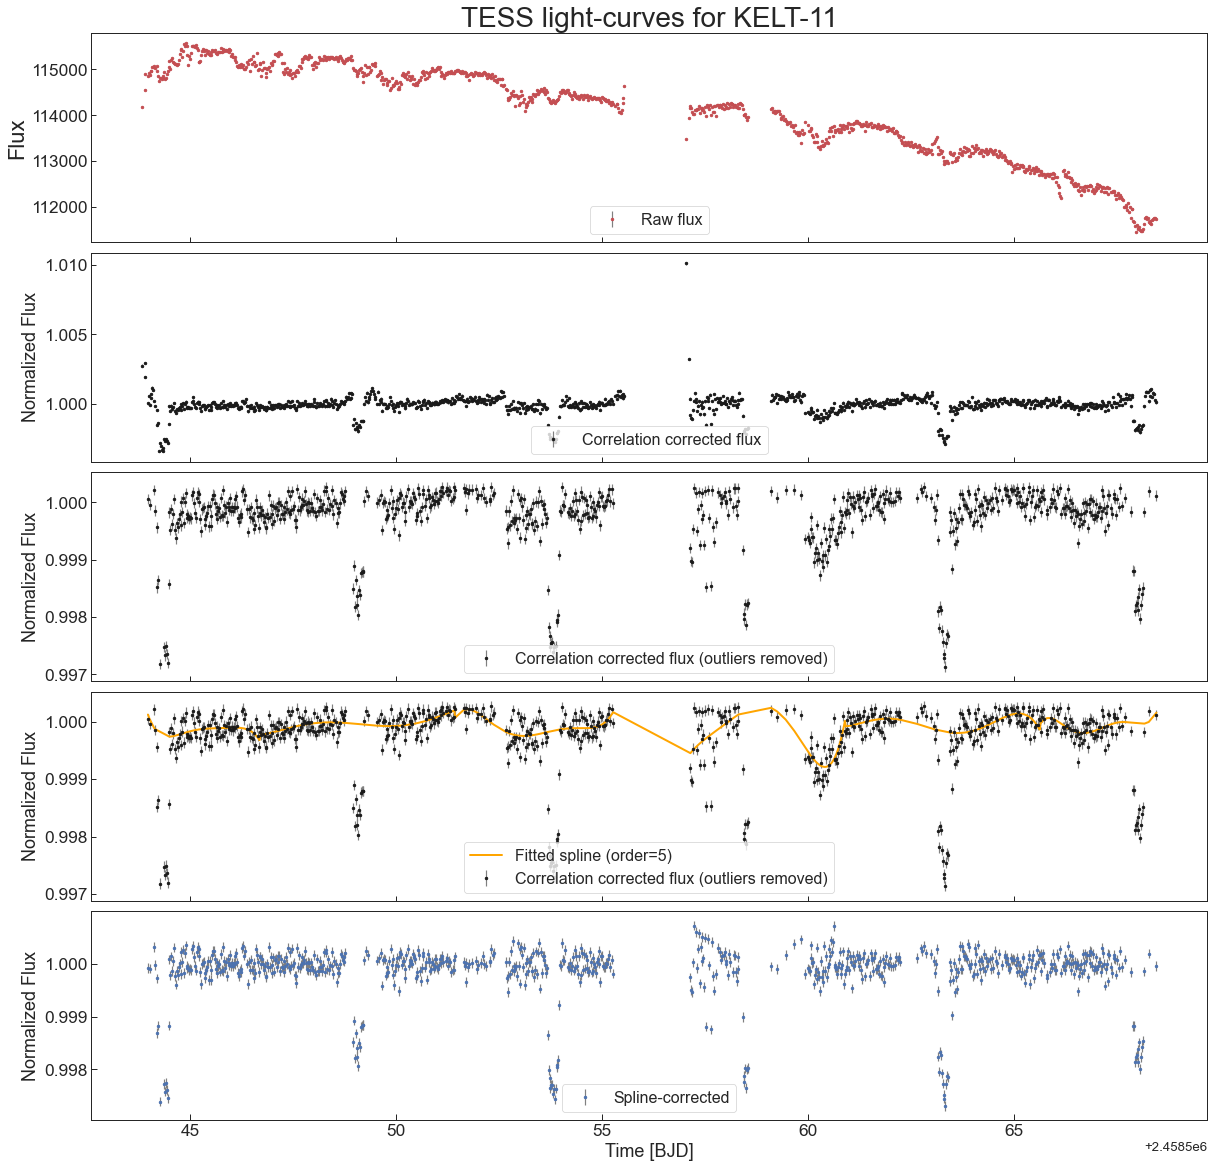

In [9]:
#### UNIFORM PRIORS MCMC FITTING ####

directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderC = 'Code Scripts/'
folderR = 'Results_(Final_Fitting-Uniform_Priors)/'
folderT = 'Test_Planets/'

Complete_Targetlist = pd.read_csv(f'{directory+folderC}'+'(2021-04-21)_Complete_Targetlist_(NO_TOI).csv')

count=4
Spline = 'None'#'hybrid_spline'
window_factor = 2       #width multpilier for fast-fit
#crop_window_factor = 2  #width multiplier for ensuring transit removal
order = 5               #order of spline polynomial
while count <= 4: 
    if Complete_Targetlist['Observed'][count] == 0:
        name = Complete_Targetlist.iloc[count]['pl_name']
        print(f'Target {name} has not yet been observed')
        count=count+1 # allows me to execute loop 
        pass

    else:
        name = Complete_Targetlist.iloc[count]['pl_name']
        Name = name[:-2]
        Name_NS = re.sub('\s+', '_', f'{Name}')
        Comp = name[-1:]
        print(name, Name, Name_NS)
        name_index = Complete_Targetlist.index[Complete_Targetlist['pl_name']==name][0]
        TIC_ID = Complete_Targetlist.iloc[count]['TIC']
        SNR = Complete_Targetlist.iloc[count]['New SNR']
        filepath = f'({count})_(Spline_Corrected + HS)_({window_factor}x_Window)_{name}/'
        path = os.path.join(directory,folderR,filepath)
        print(path)
        #print('The count is:', count)
        count=count+1 # allows me to execute loop 
        #print('The next count will be:', count)
        try:  
            os.makedirs(path, exist_ok=True)  
        except OSError as error:  
            print(error) 
            
        # b_rr
        #r_p = Complete_Targetlist['pl_radj'][name_index]
        R_p = Complete_Targetlist['pl_radj'][name_index]*R_jup
        R_pm = Complete_Targetlist['pl_radjerr2'][name_index]*R_jup 
        R_pp = Complete_Targetlist['pl_radjerr1'][name_index]*R_jup 
        if R_pm ==0:
            R_pe = R_pp
        elif R_pp ==0:
            R_pe = R_pm
        else:
            R_pe = (R_pp - R_pm) / 2
        print(R_pm, R_p, R_pp)

        #r_s = Complete_Targetlist['st_rad'][name_index]
        R_s = Complete_Targetlist['st_rad'][name_index]*R_sun
        R_sm = Complete_Targetlist['st_raderr2'][name_index]*R_sun 
        R_sp = Complete_Targetlist['st_raderr1'][name_index]*R_sun 
        if R_sm ==0:
            R_se = R_sp
        elif R_sp ==0:
            R_se = R_sm
        else:
            R_se = (R_sp - R_sm) / 2
        R_p_s = R_p / R_s
        R_p_se = R_p_s * np.sqrt((R_pe/R_p)**2 + (R_se/R_s)**2)
        Lb_rr = R_p_s - 5*R_p_se #lower bound
        if Lb_rr <= 0:
            Lb_rr = 0.001
        else:
            Lb_rr = Lb_rr
        Ub_rr = R_p_s + 5*R_p_se #upper bound
        print(R_sm, R_s, R_sp)
        #print(R_p_s - R_p_se, R_p_s, R_p_s + R_p_se)
        
        Depth = (R_p_s)**2
        star = eleanor.multi_sectors(tic = TIC_ID, sectors='all')
        #print(star)

        data = []
        TIME_ARR = []
        RAW_ARR = []
        RAW_ERR_ARR = []
        NCORR_FLUX_ARR = []
        NCORR_FLUX_ERR_ARR = []
        
        TIME_arr = []
        NCORR_FLUX_arr = []
        NCORR_FLUX_ERR_arr = []
        
        for s in star:
            datum = eleanor.TargetData(s, height=15, width=15, bkg_size=31,
                                  do_psf=True, do_pca=True, regressors='corner')
            data.append(datum) # <-- len(data) equals the number of sectors 
            #print(np.shape(datum.aperture))
            
        # datum is an eleanor.Targetdata object and data is a list of these.

        for sector, datum in enumerate(data):
            q = datum.quality == 0

            avg_sector_flux_R = np.median(datum.raw_flux[q])
            avg_sector_flux_C = np.median(datum.corr_flux[q])

            '''datum.X[q] are the lists containing the respective values for X'''

            TIME = datum.time[q]+2457000
            for i in TIME:
                TIME_ARR.append(i)
            RAW = datum.raw_flux[q]
            for i in RAW:
                RAW_ARR.append(i)
            Raw_E = datum.flux_err[q]
            for i in Raw_E:
                RAW_ERR_ARR.append(i)
            #RAW_E = np.sqrt(datum.raw_flux[q])/ np.sqrt(len(datum.raw_flux[q]))
            NRAW = datum.raw_flux[q] / np.nanmedian(datum.raw_flux[q])
            NRaw_E = datum.flux_err[q] / np.nanmedian(datum.raw_flux[q])
            #NRAW_E = np.sqrt(datum.raw_flux[q]) / (np.nanmedian(datum.raw_flux[q])*np.sqrt(len(datum.raw_flux[q])))
            NCORR = datum.corr_flux[q]/ np.nanmedian(datum.corr_flux[q])
            for i in NCORR:
                NCORR_FLUX_ARR.append(i)
            NCORR_E = np.sqrt(datum.corr_flux[q])/ (np.nanmedian(datum.corr_flux[q])*np.sqrt(len(datum.corr_flux[q])))
            for i in NCORR_E:
                NCORR_FLUX_ERR_ARR.append(i)
            
            INDICES = []
            for i in range(0, len(datum.corr_flux[q])):
                N_corrF = NCORR[i]
                N_corrFerr = (np.sqrt(datum.corr_flux[q])/ (np.nanmedian(datum.corr_flux[q])*np.sqrt(len(datum.corr_flux[q]))))[i]
                #print('Error on Corr flux is', N_corrFerr)
                #print('Depth is', Depth)
                
                if N_corrF > 1+(3*np.abs(N_corrFerr)):
                    INDICES.append(i)
                elif N_corrF < 1-(Depth + 3*np.abs(N_corrFerr)): 
                    INDICES.append(i)
                elif N_corrF < 0:
                    INDICES.append(i)
            #print(INDICES)
            #print(len(INDICES))

            TIME_d = np.delete(TIME, INDICES)
            NCORR_r = NCORR[INDICES]
            NCORR_d = np.delete(NCORR, INDICES)
            NCORR_E_d = np.delete(NCORR_E, INDICES)
            
            for i in TIME_d:
                TIME_arr.append(i)
            for j in NCORR_d:
                NCORR_FLUX_arr.append(j)
            for k in NCORR_E_d:
                NCORR_FLUX_ERR_arr.append(k)

        err_corr_flux = np.mean(NCORR_FLUX_ERR_arr)

        # cos(i)
        i = np.cos(Complete_Targetlist['pl_orbincl'][name_index]*np.pi/180)
        if i == 1:
            print('There is no entry for orbital inclination, estimating cos(i)=0.1')
            i = 0.1
        else:
            i = i

        i_p = np.cos((Complete_Targetlist['pl_orbincl'][name_index] + Complete_Targetlist['pl_orbinclerr2'][name_index])*np.pi/180)
        if i_p == 1:
            print('Estimating the upper bound for b_cosi as 0.2')
            i_p = 0.2
        else:
            i_p = i_p

        i_m = np.cos((Complete_Targetlist['pl_orbincl'][name_index] + Complete_Targetlist['pl_orbinclerr1'][name_index])*np.pi/180)
        if i_m == 1:
            print('Estimating the lower bound for b_cosi as 0.0')
            i_m = 0.0
        else:
            i_m = i_m

        # epoch
        Updated = Complete_Targetlist['rowupdate'][name_index]
        T_0 = Complete_Targetlist['pl_tranmid'][name_index]
        T_0m = Complete_Targetlist['pl_tranmiderr2'][name_index]
        T_0p = Complete_Targetlist['pl_tranmiderr1'][name_index]

        # period
        P = Complete_Targetlist['pl_orbper'][name_index]
        P_m = Complete_Targetlist['pl_orbpererr2'][name_index]
        P_p = Complete_Targetlist['pl_orbpererr1'][name_index]
        
        Dur = Complete_Targetlist['pl_trandur'][name_index]

        ### !!!
        ### MODIFY THIS AS IS THE CAUSE OF SOME ERRORS ###
        ### !!!

        # Midtransit Error Propagation to beginning of TESS data:
        print('Data begins at', TIME_arr[0], 'and initial midtransit is at', T_0)
        # number of periods between NASA T_0 and 1st data point:
        elapsed_periods = (TIME_arr[0]-T_0) / P
        
        eP = math.floor(elapsed_periods)    #periods to last transit before data
        ePplus = math.ceil(elapsed_periods) #periods to first transit in data
        print('Periods elapsed are', elapsed_periods, 'which rounded down is', eP )
        print('Upper Midtransit bound estimate is:', (T_0p + ePplus*P_p) )
        print('Lower Midtransit bound estimate is:', (T_0m + ePplus*P_m) )
        print('Period is', P, 'days')

        while TIME_arr[0] < T_0:
            with open(f'{directory+folderR}'+'Up-to-Date_Targets_(Uniform).csv', 'a', newline='') as S:
                writer = csv.writer(S)
                writer.writerow([f'{name_index}',f'{name}', 'NASA', f'{T_0}', f'{T_0m}', f'{T_0p}', f'{P}', f'{P_m}', f'{P_p}', '', 'Up-to-date', f'{Updated}', {eP}])
                writer.writerow([' '])
                break
        else:
            
            # duration
            Dur = Complete_Targetlist['pl_trandur'][name_index]
            Window = window_factor*(2*Dur + 2*np.abs(T_0m + ePplus*P_m) + 2*np.abs(T_0p + ePplus*P_p))
            if Window > P:
                VALUE = 'False'
                Window = ''
            else:
                VALUE = 'True'
                Window = Window
                
            midtransit = T_0 + (ePplus * P)

            CORRECTED_LC = []
            CORRECTED_TIME = []
            OUT_OF_T_TIME = []
            CORR_ERR = []
            SPLINE = []
            
            REM = []

            while midtransit <= np.max(TIME_arr):
                start = midtransit - (P / 2)
                end = midtransit + (P / 2)
                P_Ind = np.where( (TIME_arr>start) & (TIME_arr<=end) )[0]
                ### P_Ind lists all indices for 1 orbital period
                P_mask = np.isin(np.array(TIME_arr), np.array(TIME_arr)[P_Ind])

                P_Time = np.array(TIME_arr)[P_mask]
                P_Corr = np.array(NCORR_FLUX_arr)[P_mask]
                P_Corr_E = np.array(NCORR_FLUX_ERR_arr)[P_mask]
                ### arrays containing 1period complete data

                trans_start = midtransit - (2*(np.abs(T_0m) + np.abs(ePplus*P_m)) + Dur/2)
                trans_end = midtransit + (2*(np.abs(T_0p) + np.abs(ePplus*P_p)) + Dur/2)
                T_Ind = np.where( (P_Time > trans_start ) & (P_Time <= trans_end ) )[0]
                ### T_ind lists all the indices of the transit within this orbital period
                T_mask = np.invert(np.isin(np.array(P_Time), np.array(P_Time)[T_Ind]))                

                T_Time = P_Time[T_mask]
                T_Corr = P_Corr[T_mask]
                T_Corr_E = P_Corr_E[T_mask]
                
                if len(T_Corr) <= 5:
                    midtransit += P
                else:
                
                    ### FIT A SPLINE TO FULL OUT-OF-TRANSIT DATA
                    p = Poly.fit(T_Time, T_Corr, order)
                    q = Cheb.fit(T_Time, T_Corr, order)

                    T_SpC = (T_Corr/p(T_Time)) 
                    P_SpC = (P_Corr/p(P_Time))

                    for j in T_Time:
                        OUT_OF_T_TIME.append(j)
                    for k in P_Time:
                        CORRECTED_TIME.append(k)
                    for l in P_SpC:
                        #if l > 0:
                        CORRECTED_LC.append(l)
                        #else:
                        #    CORRECTED_LC.append(l)
                        #    REM.append()
                    for m in P_Corr_E:
                        CORR_ERR.append(m)
                    for n in p(T_Time):
                        SPLINE.append(n)
                    midtransit += P     
                    
            R = np.where(np.array(CORRECTED_LC) < 0)[0]
            print(R)
            
            CORRECTED_TIME = np.delete(CORRECTED_TIME, R)
            CORRECTED_LC = np.delete(CORRECTED_LC, R)
            CORR_ERR = np.delete(CORR_ERR, R)
            
            #print(np.array(CORRECTED_LC))
                
            fig, ax = plt.subplots(5, 1, sharex=True, sharey=False, figsize=(20,20))
            ax[0].errorbar(TIME_ARR, RAW_ARR, yerr=RAW_ERR_ARR, xerr=None, fmt='r.' ,ecolor='gray', label='Raw flux')
            ax[1].errorbar(TIME_ARR, NCORR_FLUX_ARR, yerr=NCORR_FLUX_ERR_ARR, xerr=None, fmt='k.' ,ecolor='gray', label='Correlation corrected flux')
            ax[2].errorbar(TIME_arr, NCORR_FLUX_arr, yerr=NCORR_FLUX_ERR_arr, xerr=None, fmt='k.' ,ecolor='gray', label='Correlation corrected flux (outliers removed)')
            ax[3].errorbar(np.array(TIME_arr), np.array(NCORR_FLUX_arr), np.array(NCORR_FLUX_ERR_arr), fmt='k.', ecolor='gray', label='Correlation corrected flux (outliers removed)')
            ax[3].plot(np.array(OUT_OF_T_TIME), np.array(SPLINE), color='orange', linewidth=2, label=f'Fitted spline (order={order})')
            ax[4].errorbar(np.array(CORRECTED_TIME), np.array(CORRECTED_LC), np.array(CORR_ERR), fmt='b.', ecolor='gray', label='Spline-corrected')
            ax[0].set_ylabel('Flux', fontsize=22)
            ax[0].tick_params(which='major', labelsize='xx-large')
            ax[1].set_ylabel('Normalized Flux', fontsize=18)
            ax[1].tick_params(which='major', labelsize='xx-large')
            ax[2].set_ylabel('Normalized Flux', fontsize=18)
            ax[2].tick_params(which='major', labelsize='xx-large')
            ax[3].set_ylabel('Normalized Flux', fontsize=18)
            ax[3].tick_params(which='major', labelsize='xx-large')
            ax[4].set_ylabel('Normalized Flux', fontsize=18)
            ax[4].tick_params(which='major', labelsize='xx-large')
            ax[4].set_xlabel('Time [BJD]', fontsize=18)
            ax[0].set_title(f'TESS light-curves for {Name}', fontsize=28)
                        
            ax[0].legend(loc='lower center', fontsize=16)
            ax[1].legend(loc='lower center', fontsize=16)
            ax[2].legend(loc='lower center', fontsize=16)
            ax[3].legend(loc='lower center', fontsize=16)
            ax[4].legend(loc='lower center', fontsize=16)
            #ax[3].set_title(f'Original and Spline-Corrected Light-curves for {name}')
            plt.tick_params(which='major', labelsize='xx-large', length=6)
            plt.tick_params(which='minor', labelsize='xx-large', length=4)
            #fig.text(0.075, 0.5, 'Normalized Flux', va='center', rotation='vertical', fontsize=22)
            plt.subplots_adjust(hspace=0.05)
            #plt.savefig(f'{directory+folderR+filepath+Name}_(all_light-curves).png', overwrite=True)
            plt.show()
            '''
            for a in ax:
                a.label_outer()
            
            data_allesfitter = zip(CORRECTED_TIME, CORRECTED_LC, CORR_ERR)
            LC_Data = pd.DataFrame(list(data_allesfitter), columns=['Time (JD)', 'Normalised Correlated Flux', 'Normalised Correlated Flux error'])
            LC_Data.to_csv(f'{path}'+f'{Name_NS}.csv', header=False, index=False)                    
           
            # b_rsuma
            a = Complete_Targetlist['pl_orbsmax'][name_index]*au
            a_me = Complete_Targetlist['pl_orbsmaxerr2'][name_index]*au
            a_pe = Complete_Targetlist['pl_orbsmaxerr1'][name_index]*au

            m = Complete_Targetlist['st_mass'][name_index]*M_sun # mass of star in kg
            m_me = Complete_Targetlist['st_masserr2'][name_index]*M_sun
            m_pe = Complete_Targetlist['st_masserr1'][name_index]*M_sun
            if m_me ==0:
                dm = m_pe
            elif m_pe ==0:
                dm = m_me
            else:
                dm = (m_pe - m_me) / 2

            print('Semi_major axis values are:', a_me, a, a_pe)
            print('Stellar mass valus are', m_me, m, m_pe)
            if a == 0:
                print('There is no entry for semi-major axis - estimating this using Keplers Third Law')
                if m == 0:
                    print('With no mass or semi-major axis value, this parameter cannot be estimated')
                else:
                    p = P * (24*60*60) * u.second
                    p_m = P_m * (24*60*60) * u.second
                    p_p = P_p * (24*60*60) * u.second
                    dp = (p_m + p_p) / 2

                    a_1 = ( (G*m*(p**2)) / (4*np.pi**2) )**(1/3)
                    a_1e = (a/3) * np.sqrt( (dm/m)**2 + (2*((dp/p)**2)) )

                    print('Estimate for a is', a_1, 'with error', a_1e)

                    R_a = (R_p + R_s) / a_1
                    R_ae = R_a * np.sqrt((R_pe/R_p)**2 + (R_se/R_s)**2 + (a_1e/a_1)**2)
                    Lb_rsuma = R_a - 5*R_ae
                    Ub_rsuma = R_a + 5*R_ae
                    if Lb_rsuma <= 0:
                        Lb_rsuma = 0.000001
                    else:
                        Lb_rsuma = Lb_rsuma

                    default_steps = 750
                    default_loops = 2
            else:
                R_a = (R_p + R_s) / a
                R_ae = R_a * np.sqrt((R_pe/R_p)**2 + (R_se/R_s)**2 + ((a_pe - a_me)/(2*a))**2)
                Lb_rsuma = R_a - 5*R_ae
                Ub_rsuma = R_a + 5*R_ae
                if Lb_rsuma <= 0:
                    Lb_rsuma = 0.000001
                else:
                    Lb_rsuma = Lb_rsuma

                default_steps = 0
                default_loops = 0

            print(R_a, R_ae)
            
            Cont_Ratio = Complete_Targetlist['Cont_Factor'][name_index]
            Dilution = Cont_Ratio / (1 + Cont_Ratio)

            with open(f'{directory+folderR+filepath}'+'settings.csv', 'w', newline='') as s:
                writer = csv.writer(s)
                writer.writerow(['#name', '#value'])
                #writer.writerow(['companions_phot', f'{Comp}'])
                writer.writerow(['companions_phot', 'b'])
                writer.writerow(['inst_phot', f'{Name_NS}'])
                writer.writerow(['multiprocess', 'True'])
                writer.writerow(['fast_fit', VALUE])
                writer.writerow(['fast_fit_width', f'{Window}']) #crops data to duration + 0.25days, centered on T_0
                writer.writerow(['secondary_eclipse', 'False'])
                writer.writerow(['phase_curve', 'False'])
                writer.writerow(['shift_epoch', 'True'])
                writer.writerow(['inst_for_b_epoch', 'all'])
                writer.writerow(['mcmc_nwalkers', '100'])
                writer.writerow(['mcmc_total_steps', '7500'])
                writer.writerow(['mcmc_burn_steps', '1000'])
                writer.writerow(['mcmc_thin_by', '1'])
                writer.writerow(['mcmc_pre_run_steps', f'{default_steps}'])
                writer.writerow(['mcmc_pre_run_loops', f'{default_loops}'])
                writer.writerow([f'host_ld_law_{Name_NS}', 'quad'])
                #writer.writerow([f'baseline_flux_{Name_NS}', f'{Spline}']) 
                # ^ previously using hybrid_offset

                #writer.writerow([f'baseline_flux_{name}', 'sample_offset'])
                writer.writerow([f'error_flux_{Name_NS}', 'sample'])
                #writer.writerow([f'error_flux_{name}', 'hybrid'])
                writer.writerow([f't_exp_{Name_NS}', '0.0208333'])
                writer.writerow([f't_exp_n_int_{Name_NS}', ' ']) #set to 15
                writer.writerow([f'host_N_spots_{Name_NS}', ' '])
                writer.writerow(['N_flares', ' '])
                writer.writerow(['fit_ttvs', 'False'])
                writer.writerow([f'host_grid_{Name_NS}', 'default'])
                writer.writerow([f'host_shape_{Name_NS}', 'sphere'])

            with open(f'{directory+folderR+filepath}'+'params.csv', 'w', newline='') as p:
                write = csv.writer(p)
                # name, value, standard, bounds (-)(+)
                write.writerow(['#name', 'value', 'fit', 'bounds', 'label', 'unit'])
                write.writerow(['b_rr', R_p_s, 1, f'uniform {Lb_rr} {Ub_rr}', '$R_b / R_\star$', '']) # r_planet / r_star
                write.writerow(['b_rsuma', R_a, 1, f'uniform {Lb_rsuma} {Ub_rsuma}', '$(R_\star + R_b) / a_b$', '']) # r_planet + r_star / a
                #write.writerow(['b_cosi', i, 1, f'uniform 0 1', '$\cos{i_b}$', '']) # cosine of inclination
                write.writerow(['b_cosi', i, 0, '', '$\cos{i_b}$', '']) # cosine of inclination - FIXED PARAMETER
                write.writerow(['b_epoch', f'{T_0}', 1, f'uniform {T_0 + (T_0m + ePplus*P_m)} {T_0 + (T_0p + ePplus*P_p)}', '$T_{0;b}$', '$\mathrm{JD}$']) # transit midpoint
                #write.writerow(['b_period', f'{P}', 1, f'uniform {P + 5*P_m} {P + 5*P_p}', '$P_b$', '$\mathrm{d}$']) # orbital period 
                write.writerow(['b_period', f'{P}', 1, f'uniform {P + 100*P_m} {P + 100*P_p}', '$P_b$', '$\mathrm{d}$']) # leave P blank 

                #write.writerow(['b_f_c', ..., 0, f'trunc_normal {} {}', '$\sqrt{e_b} \cos{\omega_b}$') # sqrt(e) cos(omega)
                #write.writerow(['b_f_s', ..., 0, f'trunc_normal {} {}', '$\sqrt{e_b} \sin{\omega_b}$') # sqrt(e) sin(omega)
                write.writerow([f'dil_{Name_NS}', f'{Dilution}', 0, f'trunc_normal {0} {1} {0} {0}', '$D_\mathrm{0}$', '']) # instrument dilution 
                write.writerow([f'host_ldc_q1_{Name_NS}', 0.5, 1, f'uniform {0} {1}', '$q_{1}$', '']) # 
                write.writerow([f'host_ldc_q2_{Name_NS}', 0.5, 1, f'uniform {0} {1}', '$q_{2}$', '']) # 
                write.writerow([f'b_sbratio_{Name_NS}', 0.0, 0, f'trunc_normal {0} {1} {0} {0}', '$J_{b}$', '']) # surface brightness ratio
                write.writerow([f'host_geom_albedo_{Name_NS}', 0.0, 0, f'trunc_normal {0} {1} {0} {0}', '$A_{\mathrm{geom}; host}$', '']) # geometric albedo star
                write.writerow([f'b_geom_albedo_{Name_NS}', 0.0, 0, f'trunc_normal {0} {1} {0} {0}', '$A_{\mathrm{geom}; b}$', '']) # geometric albedo planet
                write.writerow([f'host_gdc_{Name_NS}', 0.0, 0, f'trunc_normal {0} {1} {0} {0}', '$Grav. dark._{b}$', '']) # gravity darkening
                write.writerow([f'ln_err_flux_{Name_NS}', np.log(err_corr_flux), 1, f'trunc_normal -20 0 {np.log(err_corr_flux)} 0.5', '$\ln{\sigma}$', '']) # log error on flux
                # EITHER:
                #write.writerow([f'baseline_offset_flux_{name}', '1' , 0, 'uniform {1} {1}', '$\mathrm{gp: \ln{\sigma}}$', '']) # 
                #write.writerow([f'baseline_slope_flux_{name}', '0' , 0, 'uniform {0} {0}', '$\mathrm{gp: \ln{\sigma}}$', '']) # 
                # OR:
                #write.writerow([f'baseline_gp_real_lna_flux_{Name_NS}', 0.0, 1, f'uniform {-15} {15}', '$\mathrm{gp: ln sigma}$', ' ']) # 
                #write.writerow([f'baseline_gp_real_lnc_flux_{Name_NS}', 0.0, 1, f'uniform {-15} {15}', '$\mathrm{gp: ln rho}$', ' '])  

            alles = allesfitter.allesclass(f'{directory+folderR+filepath}')
            inst = f'{Name_NS}'
            print(inst)
            key = 'flux'

            alles.get_initial_guess_stellar_var(inst, key)
            allesfitter.show_initial_guess(f'{directory+folderR+filepath}', do_logprint=True, do_plot=True, return_figs=True)
            
            for style in ['full', 'phase', 'phasezoom']: #, 'phasezoom_occ', 'phase_variations']:
                # PLOTS INITIAL GUESSES
                fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
                fig.subplots_adjust(hspace=0)
                #::: alles.plot(...) data and model
                alles.plot(f'{Name_NS}','b',style,mode='initial_guess', Nsamples=20, force_binning=False, ax=axes[0])
                #Nsamples is the number of posterior best fit models plotted. - randomly chosen
                axes[0].set_title(f'{name}, '+style+' (initial guess)')
                #::: alles.plot(...) residuals
                alles.plot(f'{Name_NS}','b',style+'_residuals',mode='initial_guess', Nsamples=20, force_binning=False, ax=axes[1])
                axes[1].axhline(y=0)
                axes[1].set_title('')
                fig.savefig(f'{directory+folderR+filepath+name}_'+style+'_(initial).png', bbox_inches='tight')

            allesfitter.mcmc_fit(f'{directory+folderR+filepath}')
            allesfitter.mcmc_output(f'{directory+folderR+filepath}')

            alles = allesfitter.allesclass(f'{directory+folderR+filepath}')
            inst = f'{Name_NS}'
            key = 'flux'
            #::: load the time, flux, and flux_err
            time = alles.data[inst]['time']
            flux = alles.data[inst][key]
            flux_err = alles.data[inst]['err_scales_'+key] * alles.posterior_params_median['err_'+key+'_'+inst]

            for style in ['full', 'phase', 'phasezoom']: #, 'phasezoom_occ', 'phase_variations']:            
                # PLOTS POSTERIOR FIT VALUES
                fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
                fig.subplots_adjust(hspace=0)
                #::: alles.plot(...) data and model
                alles.plot(f'{Name_NS}','b',style,mode='posterior', Nsamples=20, force_binning=False, ax=axes[0])
                #Nsamples is the number of posterior best fit models plotted. - randomly chosen
                axes[0].set_title(f'{name}, '+style+' (posterior fits)')
                #::: alles.plot(...) residuals
                alles.plot(f'{Name_NS}','b',style+'_residuals',mode='posterior', Nsamples=20, force_binning=False, ax=axes[1])
                axes[1].axhline(y=0)
                axes[1].set_title('')
                fig.savefig(f'{directory+folderR+filepath+name}_'+style+'_(fit).png', bbox_inches='tight')

            ### Creates CSV file with input and fitted midtransit and period values ###
            Fit_Results = pd.read_csv(f'{directory+folderR+filepath}results/'+'mcmc_table.csv')
            Fitted_T_0 = Fit_Results['median'][4]
            Fitted_T_0_le = Fit_Results['lower_error'][4]
            Fitted_T_0_ue = Fit_Results['upper_error'][4]

            Fitted_P = Fit_Results['median'][5]
            Fitted_P_le = Fit_Results['lower_error'][5]
            Fitted_P_ue = Fit_Results['upper_error'][5]

            Fitted_brr = Fit_Results['median'][1]
            Fitted_brre = (float(Fit_Results['lower_error'][1]) + float(Fit_Results['upper_error'][1])) / 2
            #Fitted_SNR = (float(Fitted_brr)) / Fitted_brre
            Fitted_SNR = (float(Fitted_brr)) / (2*Fitted_brre)
            # SNR = depth / error on depth = (R_p/R_s)^2 / 2(err(R_p/R_s))

            Updated = Complete_Targetlist['rowupdate'][name_index]
            with open(f'{directory+folderR}'+'Input_and_Fitted_Values_(BrP, Fcosi).csv', 'a', newline='') as S:
                writer = csv.writer(S)
                writer.writerow([f'{name_index}',f'{name}', 'NASA', f'{T_0}', f'{T_0m}', f'{T_0p}', f'{P}', f'{P_m}', f'{P_p}', '', '', f'{Updated}'])
                #writer.writerow([f'{name_index}',f'{name}', 'Input', f'{T_0}', f'{(T_0m + eP*P_m)}', f'{(T_0p + eP*P_p)}', f'{P}', f'{5*P_m}', f'{5*P_p}', '', f'{SNR}', f'{Spline}'])
                writer.writerow([f'{name_index}',f'{name}', 'Input', f'{T_0}', f'{(T_0m + eP*P_m)}', f'{(T_0p + eP*P_p)}', f'{P}', f'{100*P_m}', f'{100*P_p}', '', f'{SNR}', f'{Spline}'])
                writer.writerow([f'{name_index}',f'{name}', 'Fit', f'{Fitted_T_0}', f'-{Fitted_T_0_le}', f'{Fitted_T_0_ue}', f'{Fitted_P}', f'-{Fitted_P_le}', f'{Fitted_P_ue}', '', f'{Fitted_SNR}'])
                writer.writerow([' '])
else:
    pass
'''

### GAUSSIAN FITTING:

In [ ]:
#### GAUSSIAN PRIORS MCMC RESULTS FILE ####
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderR = 'Results_(Final_Fitting-Gaussian_Priors)/'
with open(f'{directory+folderR}'+'Input_and_Fitted_Values_(Gaussian).csv', 'a', newline='') as s:
            writer = csv.writer(s)
            writer.writerow(['Index','Name', 'Value', 'Mid-transit time', 'Mid-transit_LE', 'Mid-transit_UE', 'Period', 'Period_LE', 'Period_UE', 'Radius_Ratio', 'Radius_Ratio_LE', 'Radius_Ratio_UE', '', 'SNR'])

with open(f'{directory+folderR}'+'Up-to-Date_Targets_(Gaussian).csv', 'a', newline='') as s:
            writer = csv.writer(s)
            writer.writerow(['Index','Name', 'Value', 'Mid-transit time', 'Mid-transit_LE', 'Mid-transit_UE', 'Period', 'Period_LE', 'Period_UE', '', '', 'Last_Update', 'Periods_inside_TESS'])


KPS-1 b KPS-1 KPS-1
/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/Results_(Final_Fitting-Gaussian_Priors)/(10)(TEST)_(Spline_Corrected + HS)_(2x_Window)_KPS-1 b/
Found star in Sector(s) 14 21
No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.




100%|██████████| 1266/1266 [00:41<00:00, 30.43it/s]


Data begins at 2458683.3615980633 and initial midtransit is at 2457508.37019
Periods elapsed are 688.6231059432997 which rounded down is 688
Upper Midtransit bound estimate is: 0.041441
Lower Midtransit bound estimate is: -0.041431
Period is 1.706291 days
[]


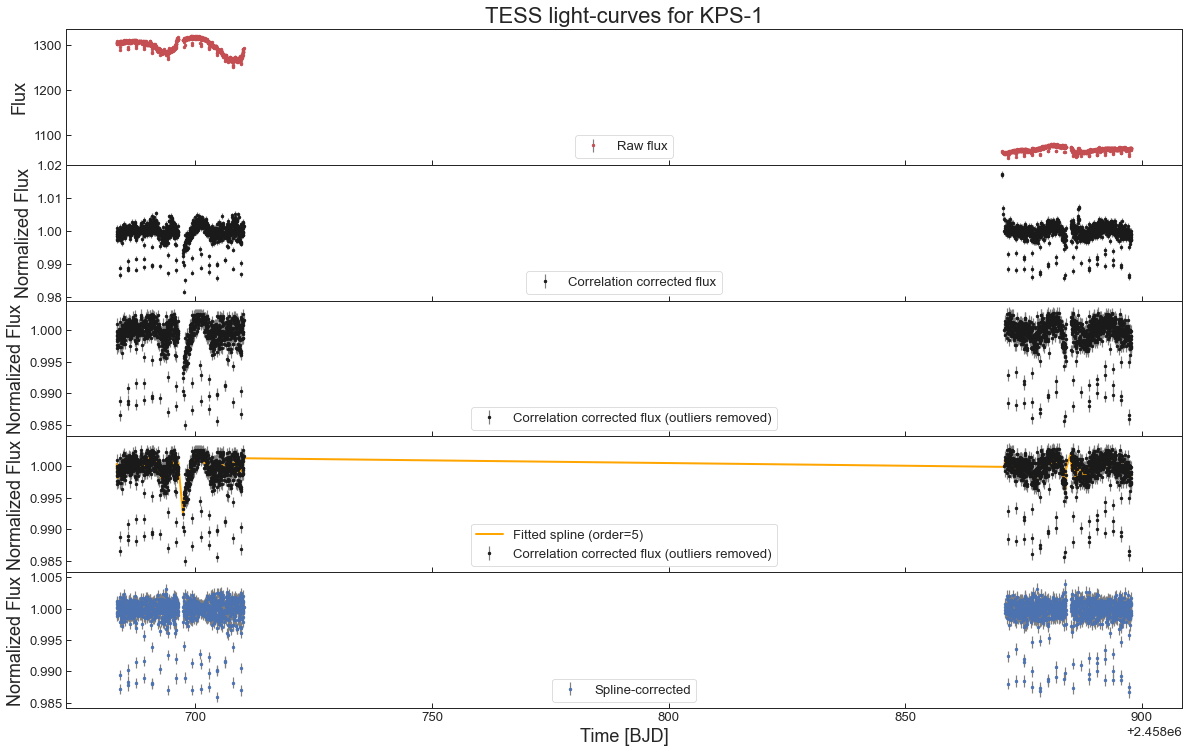

Semi_major axis values are: -149597870.70000002 m 4024182721.83 m 149597870.70000002 m
Stellar mass valus are -1.988409870698051e+29 kg 1.7696847849212654e+30 kg 1.789568883628246e+29 kg
73636760.0 m 633087000.0 m 4024182721.83 m
0.17561920241996787
0.17561920241996787 0.027675944094762643



allesfitter version
--------------------------

v1.1.2

Shifting epochs into the data center:
--------------------------

Companion b
	input epoch: 2457508.37019
	shifted epoch: 2458791.501022
	shifted by 752 periods
KPS-1


allesfitter version
--------------------------

v1.1.2

Shifting epochs into the data center:
--------------------------

Companion b
	input epoch: 2457508.37019
	shifted epoch: 2458791.501022
	shifted by 752 periods

Settings:
--------------------------

user-given:                   
companions_phot                ['b']          
inst_phot                      ['KPS-1']      
multiprocess                   True           
fast_fit                       True           
fast_f

100%|██████████| 215/215 [00:10<00:00, 20.46it/s]




allesfitter version
--------------------------

v1.1.2

Shifting epochs into the data center:
--------------------------

Companion b
	input epoch: 2457508.37019
	shifted epoch: 2458791.501022
	shifted by 752 periods

Running MCMC...
--------------------------

Running on 3 CPUs.

Running full MCMC


  0%|          | 1/7500 [00:18<39:17:38, 18.86s/it]

emcee: Exception while calling your likelihood function:


  params: [ 1.16313819e-01  1.75619198e-01  2.45879150e+06  1.70629100e+00
  5.00000022e-01  5.00000036e-01 -7.03816801e+00]
  args: []emcee: Exception while calling your likelihood function:

  params:   kwargs:[ 1.16313817e-01  1.75619197e-01  2.45879150e+06  1.70629100e+00
  4.99999998e-01  5.00000001e-01 -7.03816801e+00] 
emcee: Exception while calling your likelihood function:{}  args:
   params: 
[ 1.16313803e-01  1.75619194e-01  2.45879150e+06  1.70629100e+00
  4.99999999e-01  5.00000000e-01 -7.03816802e+00][]  exception:

  args:
 
[]  kwargs:  kwargs: {} 
{}  exception:

  exception:


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/luke740/anaconda3/lib/python3.6/site-packages/allesfitter/computer.py", line 1065, in calculate_lnlike_total
    model = calculate_model(params, inst, key)
  File "/home/luke740/anaconda3/lib/python3.6/site-packages/emcee-3.0.2-py3.6.egg/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/luke740/anaconda3/lib/python3.6/site-packages/emcee-3.0.2-py3.6.egg/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/luke740/anaconda3/lib/python3.6/site-packages/allesfitter/mcmc.py", line 101, in mcmc_lnprob
    ln = mcmc_lnlike(theta)
  File "/home/luke740/anaconda3/lib/python3.6/site-packages/allesfitter/mcmc.py", line 46, in mcmc_lnlike
    lnlike = calculate_lnlike_total(params)
  File "/home/luke740/anaconda3/lib/python3.6/site-packages/emcee-3.0.2-py3.6.egg/emcee/ensemble

  File "/home/luke740/anaconda3/lib/python3.6/site-packages/allesfitter/computer.py", line 1317, in calculate_model
    depth += ( 1. - flux_fct(params, inst, companion, xx=xx, settings=settings) )
  File "/home/luke740/anaconda3/lib/python3.6/site-packages/emcee-3.0.2-py3.6.egg/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/luke740/anaconda3/lib/python3.6/site-packages/allesfitter/computer.py", line 316, in flux_fct_full
    model_flux, model_flux1, model_flux2 = flux_subfct_ellc(params, inst, companion, xx=xx, settings=settings, t_exp=t_exp, n_int=n_int, return_fluxes=True)
  File "/home/luke740/anaconda3/lib/python3.6/site-packages/allesfitter/mcmc.py", line 101, in mcmc_lnprob
    ln = mcmc_lnlike(theta)
  File "/home/luke740/anaconda3/lib/python3.6/site-packages/allesfitter/computer.py", line 429, in flux_subfct_ellc
    verbose =     False
  File "/home/luke740/anaconda3/lib/python3.6/site-packages/allesfitter/computer.py",

KeyboardInterrupt: 

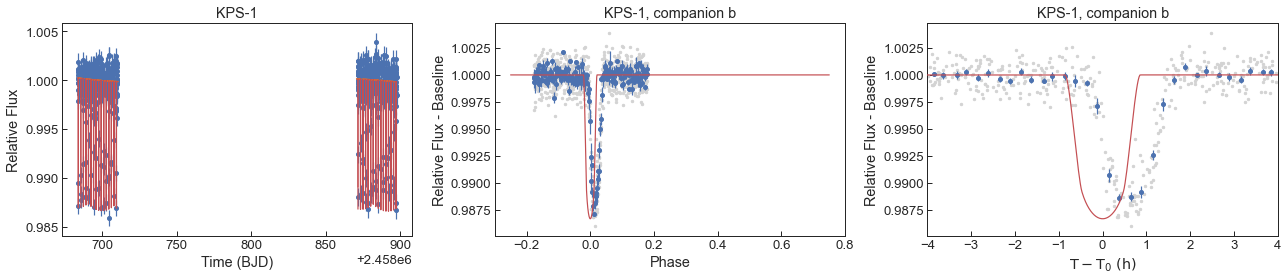

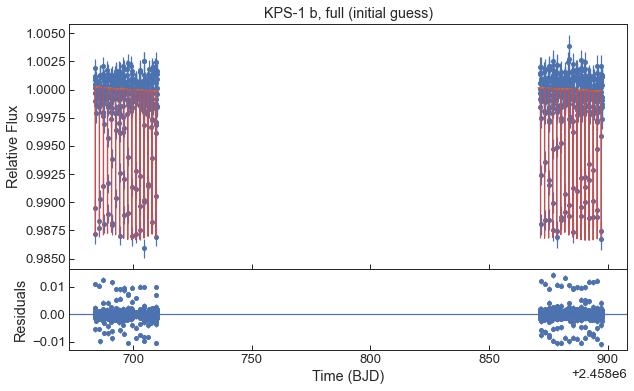

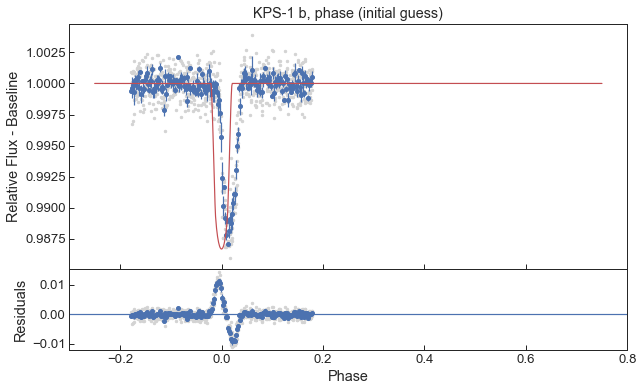

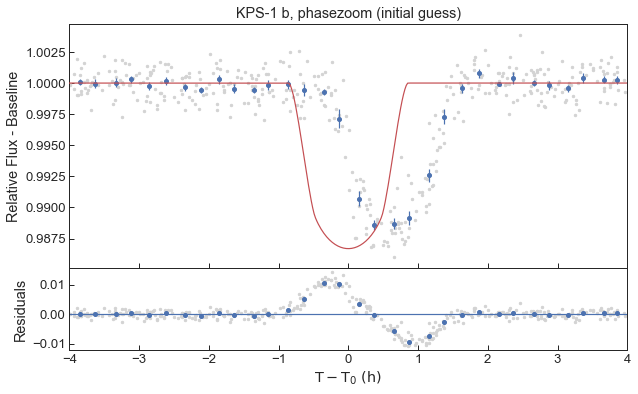

In [2]:
#### GAUSSIAN PRIORS MCMC FITTING ####
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderC = 'Code Scripts/'
folderR = 'Results_(Final_Fitting-Gaussian_Priors)/'

Complete_Targetlist = pd.read_csv(f'{directory+folderC}'+'(2021-04-21)_Complete_Targetlist_(NO_TOI).csv')

count=10
Spline = 'hybrid_spline'         #previously 'hybrid_spline'
window_factor = 2       #width multiplier for fast-fit
#crop_window_factor = 2  #width multiplier for ensuring transit removal
order = 5               #order of spline polynomial
while count <= 10: 
    if Complete_Targetlist['Observed'][count] == 0:
        name = Complete_Targetlist.iloc[count]['pl_name']
        print(f'Target {name} has not yet been observed')
        count=count+1 # allows me to execute loop 
        pass

    else:
        name = Complete_Targetlist.iloc[count]['pl_name']
        Name = name[:-2]
        Name_NS = re.sub('\s+', '_', f'{Name}')
        Comp = name[-1:]
        print(name, Name, Name_NS)
        name_index = Complete_Targetlist.index[Complete_Targetlist['pl_name']==name][0]
        TIC_ID = Complete_Targetlist.iloc[count]['TIC']
        SNR = Complete_Targetlist.iloc[count]['New SNR']
        filepath = f'({count})(TEST)_(Spline_Corrected + HS)_({window_factor}x_Window)_{name}/'
        path = os.path.join(directory,folderR,filepath)
        print(path)
        count=count+1 # allows me to execute loop 
        try:  
            os.makedirs(path, exist_ok=True)  
        except OSError as error:  
            print(error) 
            
        # b_rr
        R_p = Complete_Targetlist['pl_radj'][name_index]*R_jup
        R_pm = Complete_Targetlist['pl_radjerr2'][name_index]*R_jup 
        R_pp = Complete_Targetlist['pl_radjerr1'][name_index]*R_jup 
        if R_pm ==0:
            R_pe = R_pp
        elif R_pp ==0:
            R_pe = R_pm
        else:
            R_pe = (R_pp - R_pm) / 2
        #print(R_pm, R_p, R_pp)

        R_s = Complete_Targetlist['st_rad'][name_index]*R_sun
        R_sm = Complete_Targetlist['st_raderr2'][name_index]*R_sun 
        R_sp = Complete_Targetlist['st_raderr1'][name_index]*R_sun 
        if R_sm ==0:
            R_se = R_sp
        elif R_sp ==0:
            R_se = R_sm
        else:
            R_se = (R_sp - R_sm) / 2
        R_p_s = R_p / R_s
        R_p_se = R_p_s * np.sqrt((R_pe/R_p)**2 + (R_se/R_s)**2)
        Lb_rr = R_p_s - 5*R_p_se #lower bound
        if Lb_rr <= 0:
            Lb_rr = 0.001
        else:
            Lb_rr = Lb_rr
        Ub_rr = R_p_s + 5*R_p_se #upper bound
        #print(R_sm, R_s, R_sp)
        #print(R_p_s - R_p_se, R_p_s, R_p_s + R_p_se)
        
        Depth = (R_p_s)**2
        star = eleanor.multi_sectors(tic = TIC_ID, sectors='all')
        #print(star)

        data = []
        TIME_ARR = []
        RAW_ARR = []
        RAW_ERR_ARR = []
        NCORR_FLUX_ARR = []
        NCORR_FLUX_ERR_ARR = []
        
        TIME_arr = []
        NCORR_FLUX_arr = []
        NCORR_FLUX_ERR_arr = []
        
        for s in star:
            datum = eleanor.TargetData(s, height=15, width=15, bkg_size=31,
                                  do_psf=True, do_pca=True, regressors='corner')
            data.append(datum) # <-- len(data) equals the number of sectors 
            #print(np.shape(datum.aperture))
            
        # datum is an eleanor.Targetdata object and data is a list of these.

        for sector, datum in enumerate(data):
            q = datum.quality == 0

            avg_sector_flux_R = np.median(datum.raw_flux[q])
            avg_sector_flux_C = np.median(datum.corr_flux[q])

            '''datum.X[q] are the lists containing the respective values for X'''

            TIME = datum.time[q]+2457000
            for i in TIME:
                TIME_ARR.append(i)
            RAW = datum.raw_flux[q]
            for i in RAW:
                RAW_ARR.append(i)
            Raw_E = datum.flux_err[q]
            for i in Raw_E:
                RAW_ERR_ARR.append(i)
            #RAW_E = np.sqrt(datum.raw_flux[q])/ np.sqrt(len(datum.raw_flux[q]))
            NRAW = datum.raw_flux[q] / np.nanmedian(datum.raw_flux[q])
            NRaw_E = datum.flux_err[q] / np.nanmedian(datum.raw_flux[q])
            #NRAW_E = np.sqrt(datum.raw_flux[q]) / (np.nanmedian(datum.raw_flux[q])*np.sqrt(len(datum.raw_flux[q])))
            NCORR = datum.corr_flux[q]/ np.nanmedian(datum.corr_flux[q])
            for i in NCORR:
                NCORR_FLUX_ARR.append(i)
            NCORR_E = np.sqrt(datum.corr_flux[q])/ (np.nanmedian(datum.corr_flux[q])*np.sqrt(len(datum.corr_flux[q])))
            for i in NCORR_E:
                NCORR_FLUX_ERR_ARR.append(i)
            
            INDICES = []
            for i in range(0, len(datum.corr_flux[q])):
                N_corrF = NCORR[i]
                N_corrFerr = (np.sqrt(datum.corr_flux[q])/ (np.nanmedian(datum.corr_flux[q])*np.sqrt(len(datum.corr_flux[q]))))[i]
                #print('Error on Corr flux is', N_corrFerr)
                #print('Depth is', Depth)
                
                if N_corrF > 1+(3*np.abs(N_corrFerr)):
                    INDICES.append(i)
                elif N_corrF < 1-(Depth + 3*np.abs(N_corrFerr)): 
                    INDICES.append(i)
                elif N_corrF < 0:
                    INDICES.append(i)
            #print(INDICES)
            #print(len(INDICES))

            TIME_d = np.delete(TIME, INDICES)
            NCORR_r = NCORR[INDICES]
            NCORR_d = np.delete(NCORR, INDICES)
            NCORR_E_d = np.delete(NCORR_E, INDICES)
            
            for i in TIME_d:
                TIME_arr.append(i)
            for j in NCORR_d:
                NCORR_FLUX_arr.append(j)
            for k in NCORR_E_d:
                NCORR_FLUX_ERR_arr.append(k)

        err_corr_flux = np.mean(NCORR_FLUX_ERR_arr)

        # cos(i)
        i = np.cos(Complete_Targetlist['pl_orbincl'][name_index]*np.pi/180)
        if i == 1:
            print('There is no entry for orbital inclination, estimating cos(i)=0.1')
            i = 0.1
        else:
            i = i

        i_p = np.cos((Complete_Targetlist['pl_orbincl'][name_index] + Complete_Targetlist['pl_orbinclerr2'][name_index])*np.pi/180)
        if i_p == 1:
            print('Estimating the upper bound for b_cosi as 0.2')
            i_p = 0.2
        else:
            i_p = i_p

        i_m = np.cos((Complete_Targetlist['pl_orbincl'][name_index] + Complete_Targetlist['pl_orbinclerr1'][name_index])*np.pi/180)
        if i_m == 1:
            print('Estimating the lower bound for b_cosi as 0.0')
            i_m = 0.0
        else:
            i_m = i_m

        # epoch
        Updated = Complete_Targetlist['rowupdate'][name_index]
        T_0 = Complete_Targetlist['pl_tranmid'][name_index]
        T_0m = Complete_Targetlist['pl_tranmiderr2'][name_index]
        T_0p = Complete_Targetlist['pl_tranmiderr1'][name_index]

        # period
        P = Complete_Targetlist['pl_orbper'][name_index]
        P_m = Complete_Targetlist['pl_orbpererr2'][name_index]
        P_p = Complete_Targetlist['pl_orbpererr1'][name_index]
        
        Dur = Complete_Targetlist['pl_trandur'][name_index]

        ### !!!
        ### MODIFY THIS AS IS THE CAUSE OF SOME ERRORS ###
        ### !!!

        # Midtransit Error Propagation to beginning of TESS data:
        print('Data begins at', TIME_arr[0], 'and initial midtransit is at', T_0)
        # number of periods between NASA T_0 and 1st data point:
        elapsed_periods = (TIME_arr[0]-T_0) / P
        
        eP = math.floor(elapsed_periods)    #periods to last transit before data
        ePplus = math.ceil(elapsed_periods) #periods to first transit in data
        print('Periods elapsed are', elapsed_periods, 'which rounded down is', eP )
        print('Upper Midtransit bound estimate is:', (T_0p + ePplus*P_p) )
        print('Lower Midtransit bound estimate is:', (T_0m + ePplus*P_m) )
        print('Period is', P, 'days')

        while TIME_arr[0] < T_0:
            with open(f'{directory+folderR}'+'Up-to-Date_Targets_(Gaussian).csv', 'a', newline='') as S:
                writer = csv.writer(S)
                writer.writerow([f'{name_index}',f'{name}', 'NASA', f'{T_0}', f'{T_0m}', f'{T_0p}', f'{P}', f'{P_m}', f'{P_p}', '', 'Up-to-date', f'{Updated}', {eP}])
                writer.writerow([' '])
                break
        else:
            
            # duration
            Dur = Complete_Targetlist['pl_trandur'][name_index]
            Window = window_factor*(2*Dur + 2*np.abs(T_0m + ePplus*P_m) + 2*np.abs(T_0p + ePplus*P_p))
            if Window > P:
                VALUE = 'False'
                Window = ''
            else:
                VALUE = 'True'
                Window = Window
                
            midtransit = T_0 + (ePplus * P)

            CORRECTED_LC = []
            CORRECTED_TIME = []
            OUT_OF_T_TIME = []
            CORR_ERR = []
            SPLINE = []
            
            REM = []

            while midtransit <= np.max(TIME_arr):
                start = midtransit - (P / 2)
                end = midtransit + (P / 2)
                P_Ind = np.where( (TIME_arr>start) & (TIME_arr<=end) )[0]
                ### P_Ind lists all indices for 1 orbital period
                P_mask = np.isin(np.array(TIME_arr), np.array(TIME_arr)[P_Ind])

                P_Time = np.array(TIME_arr)[P_mask]
                P_Corr = np.array(NCORR_FLUX_arr)[P_mask]
                P_Corr_E = np.array(NCORR_FLUX_ERR_arr)[P_mask]
                ### arrays containing 1period complete data

                trans_start = midtransit - (2*(np.abs(T_0m) + np.abs(ePplus*P_m)) + Dur/2)
                trans_end = midtransit + (2*(np.abs(T_0p) + np.abs(ePplus*P_p)) + Dur/2)
                T_Ind = np.where( (P_Time > trans_start ) & (P_Time <= trans_end ) )[0]
                ### T_ind lists all the indices of the transit within this orbital period
                T_mask = np.invert(np.isin(np.array(P_Time), np.array(P_Time)[T_Ind]))                

                T_Time = P_Time[T_mask]
                T_Corr = P_Corr[T_mask]
                T_Corr_E = P_Corr_E[T_mask]
                
                if len(T_Corr) <= 5:
                    midtransit += P
                else:
                
                    ### FIT A SPLINE TO FULL OUT-OF-TRANSIT DATA
                    p = Poly.fit(T_Time, T_Corr, order)
                    q = Cheb.fit(T_Time, T_Corr, order)

                    T_SpC = (T_Corr/p(T_Time)) 
                    P_SpC = (P_Corr/p(P_Time))

                    for j in T_Time:
                        OUT_OF_T_TIME.append(j)
                    for k in P_Time:
                        CORRECTED_TIME.append(k)
                    for l in P_SpC:
                        #if l > 0:
                        CORRECTED_LC.append(l)
                        #else:
                        #    CORRECTED_LC.append(l)
                        #    REM.append()
                    for m in P_Corr_E:
                        CORR_ERR.append(m)
                    for n in p(T_Time):
                        SPLINE.append(n)
                    midtransit += P     
                    
            R = np.where(np.array(CORRECTED_LC) < 0)[0]
            print(R)
            
            CORRECTED_TIME = np.delete(CORRECTED_TIME, R)
            CORRECTED_LC = np.delete(CORRECTED_LC, R)
            CORR_ERR = np.delete(CORR_ERR, R)
            
            #print(np.array(CORRECTED_LC))
                
            fig, ax = plt.subplots(5, 1, sharex=True, sharey=False, figsize=(20,12.5))
            ax[0].errorbar(TIME_ARR, RAW_ARR, yerr=RAW_ERR_ARR, xerr=None, fmt='r.' ,ecolor='gray', label='Raw flux')
            ax[1].errorbar(TIME_ARR, NCORR_FLUX_ARR, yerr=NCORR_FLUX_ERR_ARR, xerr=None, fmt='k.' ,ecolor='gray', label='Correlation corrected flux')
            ax[2].errorbar(TIME_arr, NCORR_FLUX_arr, yerr=NCORR_FLUX_ERR_arr, xerr=None, fmt='k.' ,ecolor='gray', label='Correlation corrected flux (outliers removed)')
            ax[3].errorbar(np.array(TIME_arr), np.array(NCORR_FLUX_arr), np.array(NCORR_FLUX_ERR_arr), fmt='k.', ecolor='gray', label='Correlation corrected flux (outliers removed)')
            ax[3].plot(np.array(OUT_OF_T_TIME), np.array(SPLINE), color='orange', linewidth=2, label=f'Fitted spline (order={order})')
            ax[4].errorbar(np.array(CORRECTED_TIME), np.array(CORRECTED_LC), np.array(CORR_ERR), fmt='b.', ecolor='gray', label='Spline-corrected')
            ax[0].set_ylabel('Flux', fontsize=18)
            ax[1].set_ylabel('Normalized Flux', fontsize=18)
            ax[2].set_ylabel('Normalized Flux', fontsize=18)
            ax[3].set_ylabel('Normalized Flux', fontsize=18)
            ax[4].set_ylabel('Normalized Flux', fontsize=18)
            ax[4].set_xlabel('Time [BJD]', fontsize=18)
            ax[0].set_title(f'TESS light-curves for {Name}', fontsize=22)
                        
            ax[0].legend(loc='lower center')
            ax[1].legend(loc='lower center')
            ax[2].legend(loc='lower center')
            ax[3].legend(loc='lower center')
            ax[4].legend(loc='lower center')
            #ax[3].set_title(f'Original and Spline-Corrected Light-curves for {name}')
            plt.subplots_adjust(hspace=0)
            plt.savefig(f'{directory+folderR+filepath+Name}_(all_light-curves).png', overwrite=True)
            plt.show()
            
            for a in ax:
                a.label_outer()
            
            data_allesfitter = zip(CORRECTED_TIME, CORRECTED_LC, CORR_ERR)
            LC_Data = pd.DataFrame(list(data_allesfitter), columns=['Time (JD)', 'Normalised Correlated Flux', 'Normalised Correlated Flux error'])
            LC_Data.to_csv(f'{path}'+f'{Name_NS}.csv', header=False, index=False)                
           
            # b_rsuma
            a = Complete_Targetlist['pl_orbsmax'][name_index]*au
            a_me = Complete_Targetlist['pl_orbsmaxerr2'][name_index]*au
            a_pe = Complete_Targetlist['pl_orbsmaxerr1'][name_index]*au

            m = Complete_Targetlist['st_mass'][name_index]*M_sun # mass of star in kg
            m_me = Complete_Targetlist['st_masserr2'][name_index]*M_sun
            m_pe = Complete_Targetlist['st_masserr1'][name_index]*M_sun
            if m_me ==0:
                dm = m_pe
            elif m_pe ==0:
                dm = m_me
            else:
                dm = (m_pe - m_me) / 2

            print('Semi_major axis values are:', a_me, a, a_pe)
            print('Stellar mass valus are', m_me, m, m_pe)
            if a == 0:
                print('There is no entry for semi-major axis - estimating this using Keplers Third Law')
                if m == 0:
                    print('With no mass or semi-major axis value, this parameter cannot be estimated')
                else:
                    p = P * (24*60*60) * u.second
                    p_m = P_m * (24*60*60) * u.second
                    p_p = P_p * (24*60*60) * u.second
                    dp = (p_m + p_p) / 2

                    a_1 = ( (G*m*(p**2)) / (4*np.pi**2) )**(1/3)
                    a_1e = (a/3) * np.sqrt( (dm/m)**2 + (2*((dp/p)**2)) )

                    print('Estimate for a is', a_1, 'with error', a_1e)

                    R_a = (R_p + R_s) / a_1
                    R_ae = R_a * np.sqrt((R_pe/R_p)**2 + (R_se/R_s)**2 + (a_1e/a_1)**2)
                    #Lb_rsuma = R_a - 5*R_ae
                    #Ub_rsuma = R_a + 5*R_ae
                    #if Lb_rsuma <= 0:
                    #    Lb_rsuma = 0.000001
                    #else:
                    #    Lb_rsuma = Lb_rsuma

                    default_steps = 750
                    default_loops = 2
            else:
                print(R_p, R_s, a)
                R_a = (R_p + R_s) / a
                print(R_a)
                R_ae = R_a * np.sqrt((R_pe/R_p)**2 + (R_se/R_s)**2 + ((a_pe - a_me)/(2*a))**2)
                #Lb_rsuma = R_a - 5*R_ae
                #Ub_rsuma = R_a + 5*R_ae
                #if Lb_rsuma <= 0:
                #    Lb_rsuma = 0.000001
                #else:
                #    Lb_rsuma = Lb_rsuma

                default_steps = 0
                default_loops = 0

            print(R_a, R_ae)
            
            Cont_Ratio = Complete_Targetlist['Cont_Factor'][name_index]
            Dilution = Cont_Ratio / (1 + Cont_Ratio)

            with open(f'{directory+folderR+filepath}'+'settings.csv', 'w', newline='') as s:
                writer = csv.writer(s)
                writer.writerow(['#name', '#value'])
                #writer.writerow(['companions_phot', f'{Comp}'])
                writer.writerow(['companions_phot', 'b'])
                writer.writerow(['inst_phot', f'{Name_NS}'])
                writer.writerow(['multiprocess', 'True'])
                writer.writerow(['fast_fit', VALUE])
                writer.writerow(['fast_fit_width', f'{Window}']) #crops data to duration + 0.25days, centered on T_0
                writer.writerow(['secondary_eclipse', 'False'])
                writer.writerow(['phase_curve', 'False'])
                writer.writerow(['shift_epoch', 'True'])
                writer.writerow(['inst_for_b_epoch', 'all'])
                writer.writerow(['mcmc_nwalkers', '100'])
                writer.writerow(['mcmc_total_steps', '7500'])
                writer.writerow(['mcmc_burn_steps', '1000'])
                writer.writerow(['mcmc_thin_by', '1'])
                writer.writerow(['mcmc_pre_run_steps', f'{default_steps}'])
                writer.writerow(['mcmc_pre_run_loops', f'{default_loops}'])
                writer.writerow([f'host_ld_law_{Name_NS}', 'quad'])
                writer.writerow([f'baseline_flux_{Name_NS}', f'{Spline}']) 
                writer.writerow([f'error_flux_{Name_NS}', 'sample'])
                #writer.writerow([f'error_flux_{name}', 'hybrid'])
                writer.writerow([f't_exp_{Name_NS}', '0.0208333'])
                writer.writerow([f't_exp_n_int_{Name_NS}', '10']) #set to 15
                writer.writerow([f'host_N_spots_{Name_NS}', ' '])
                writer.writerow(['N_flares', ' '])
                writer.writerow(['fit_ttvs', 'False'])
                writer.writerow([f'host_grid_{Name_NS}', 'default'])
                writer.writerow([f'host_shape_{Name_NS}', 'sphere'])

            with open(f'{directory+folderR+filepath}'+'params.csv', 'w', newline='') as p:
                write = csv.writer(p)
                # name, value, standard, bounds (-)(+)
                # For Gaussian / Normal format is normal mu sigma
                write.writerow(['#name', 'value', 'fit', 'bounds', 'label', 'unit'])
                # b_rr      has 5\sigma bounds
                write.writerow(['b_rr', R_p_s, 1, f'normal {R_p_s} {R_p_se}', '$R_b / R_\star$', '']) # r_planet / r_star
                # b_rsuma   has 5\sigma bounds
                write.writerow(['b_rsuma', R_a, 1, f'normal {R_a} {R_ae}', '$(R_\star + R_b) / a_b$', '']) # r_planet + r_star / a
                # b_cosi    is FIXED
                write.writerow(['b_cosi', i, 0, f'normal {i} {(np.abs(i_p) + np.abs(i_m)) / 2}', '$\cos{i_b}$', '']) # cosine of inclination - FIXED PARAMETER
                # epoch     has propagated bounds
                write.writerow(['b_epoch', f'{T_0}', 1, f'normal {T_0} {( (np.abs(T_0m) + np.abs(ePplus*P_m)) + np.abs(T_0p + ePplus*P_p) ) / 2}', '$T_{0;b}$', '$\mathrm{JD}$']) # transit midpoint
                # period    has 5\sigma bounds
                write.writerow(['b_period', f'{P}', 1, f'normal {P} {(np.abs(P_m) + np.abs(P_p)) / 2}', '$P_b$', '$\mathrm{d}$']) # orbital period

                #write.writerow(['b_f_c', ..., 0, f'trunc_normal {} {}', '$\sqrt{e_b} \cos{\omega_b}$') # sqrt(e) cos(omega)
                #write.writerow(['b_f_s', ..., 0, f'trunc_normal {} {}', '$\sqrt{e_b} \sin{\omega_b}$') # sqrt(e) sin(omega)
                write.writerow([f'dil_{Name_NS}', f'{Dilution}', 0, f'normal {Dilution} {0}', '$D_\mathrm{0}$', '']) # instrument dilution 
                # LDCs q1 and q2 explore the full range of parameter space
                write.writerow([f'host_ldc_q1_{Name_NS}', 0.5, 1, f'uniform {0} {1}', '$q_{1}$', '']) # 
                write.writerow([f'host_ldc_q2_{Name_NS}', 0.5, 1, f'uniform {0} {1}', '$q_{2}$', '']) # 
                
                write.writerow([f'b_sbratio_{Name_NS}', 0.0, 0, f'trunc_normal {0} {1} {0} {0}', '$J_{b}$', '']) # surface brightness ratio
                write.writerow([f'host_geom_albedo_{Name_NS}', 0.0, 0, f'trunc_normal {0} {1} {0} {0}', '$A_{\mathrm{geom}; host}$', '']) # geometric albedo star
                write.writerow([f'b_geom_albedo_{Name_NS}', 0.0, 0, f'trunc_normal {0} {1} {0} {0}', '$A_{\mathrm{geom}; b}$', '']) # geometric albedo planet
                write.writerow([f'host_gdc_{Name_NS}', 0.0, 0, f'trunc_normal {0} {1} {0} {0}', '$Grav. dark._{b}$', '']) # gravity darkening
                
                write.writerow([f'ln_err_flux_{Name_NS}', np.log(err_corr_flux), 1, f'trunc_normal -20 0 {np.log(err_corr_flux)} 0.5', '$\ln{\sigma}$', '']) # log error on flux
                
            alles = allesfitter.allesclass(f'{directory+folderR+filepath}')
            inst = f'{Name_NS}'
            print(inst)
            key = 'flux'

            alles.get_initial_guess_stellar_var(inst, key)
            allesfitter.show_initial_guess(f'{directory+folderR+filepath}', do_logprint=True, do_plot=True, return_figs=True)
            
            for style in ['full', 'phase', 'phasezoom']: #, 'phasezoom_occ', 'phase_variations']:
                # PLOTS INITIAL GUESSES
                fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
                fig.subplots_adjust(hspace=0)
                #::: alles.plot(...) data and model
                alles.plot(f'{Name_NS}','b',style,mode='initial_guess', Nsamples=20, force_binning=False, ax=axes[0])
                #Nsamples is the number of posterior best fit models plotted. - randomly chosen
                axes[0].set_title(f'{name}, '+style+' (initial guess)')
                #::: alles.plot(...) residuals
                alles.plot(f'{Name_NS}','b',style+'_residuals',mode='initial_guess', Nsamples=20, force_binning=False, ax=axes[1])
                axes[1].axhline(y=0)
                axes[1].set_title('')
                fig.savefig(f'{directory+folderR+filepath+name}_'+style+'_(initial).png', bbox_inches='tight')

            allesfitter.mcmc_fit(f'{directory+folderR+filepath}')
            allesfitter.mcmc_output(f'{directory+folderR+filepath}')

            alles = allesfitter.allesclass(f'{directory+folderR+filepath}')
            inst = f'{Name_NS}'
            key = 'flux'
            #::: load the time, flux, and flux_err
            time = alles.data[inst]['time']
            flux = alles.data[inst][key]
            flux_err = alles.data[inst]['err_scales_'+key] * alles.posterior_params_median['err_'+key+'_'+inst]

            for style in ['full', 'phase', 'phasezoom']: #, 'phasezoom_occ', 'phase_variations']:            
                # PLOTS POSTERIOR FIT VALUES
                fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
                fig.subplots_adjust(hspace=0)
                #::: alles.plot(...) data and model
                alles.plot(f'{Name_NS}','b',style,mode='posterior', Nsamples=20, force_binning=False, ax=axes[0])
                #Nsamples is the number of posterior best fit models plotted. - randomly chosen
                axes[0].set_title(f'{name}, '+style+' (posterior fits)')
                #::: alles.plot(...) residuals
                alles.plot(f'{Name_NS}','b',style+'_residuals',mode='posterior', Nsamples=20, force_binning=False, ax=axes[1])
                axes[1].axhline(y=0)
                axes[1].set_title('')
                fig.savefig(f'{directory+folderR+filepath+name}_'+style+'_(fit).png', bbox_inches='tight')

            ### Creates CSV file with input and fitted midtransit and period values ###
            Fit_Results = pd.read_csv(f'{directory+folderR+filepath}results/'+'mcmc_table.csv')
            Fitted_T_0 = Fit_Results['median'][4]
            Fitted_T_0_le = Fit_Results['lower_error'][4]
            Fitted_T_0_ue = Fit_Results['upper_error'][4]

            Fitted_P = Fit_Results['median'][5]
            Fitted_P_le = Fit_Results['lower_error'][5]
            Fitted_P_ue = Fit_Results['upper_error'][5]

            Fitted_brr = Fit_Results['median'][1]
            Fitted_brr_le = float(Fit_Results['lower_error'][1])
            Fitted_brr_ue = float(Fit_Results['upper_error'][1])
            Fitted_brre = (float(Fit_Results['lower_error'][1]) + float(Fit_Results['upper_error'][1])) / 2
            #Fitted_SNR = (float(Fitted_brr)) / Fitted_brre
            Fitted_SNR = (float(Fitted_brr)) / (2*Fitted_brre)
            # SNR = depth / error on depth = (R_p/R_s)^2 / 2(err(R_p/R_s))

            Updated = Complete_Targetlist['rowupdate'][name_index]
            with open(f'{directory+folderR}'+'Input_and_Fitted_Values_(Gaussian).csv', 'a', newline='') as S:
                writer = csv.writer(S)
                writer.writerow([f'{name_index}',f'{name}', 'NASA', f'{T_0}', f'{T_0m}', f'{T_0p}', f'{P}', f'{P_m}', f'{P_p}', '', '', '', '', '', '', '',f'{Updated}'])
                writer.writerow([f'{name_index}',f'{name}', 'Input', f'{T_0}', f'{( (np.abs(T_0m) + np.abs(ePplus*P_m)) + np.abs(T_0p + ePplus*P_p) ) / 2}', '', f'{P}', f'{(np.abs(P_m) + np.abs(P_p)) / 2}', '', '', '', '', '', f'{SNR}'])
                writer.writerow([f'{name_index}',f'{name}', 'Fit', f'{Fitted_T_0}', f'-{Fitted_T_0_le}', f'{Fitted_T_0_ue}', f'{Fitted_P}', f'-{Fitted_P_le}', f'{Fitted_P_ue}', f'{Fitted_brr}', f'-{Fitted_brr_le}', f'{Fitted_brr_ue}', '', f'{Fitted_SNR}'])
                writer.writerow([' '])
else:
    pass


In [ ]:
factor = 2
midtransit = T_0 + (ePplus * P)

CORRECTED_LC = []
CORRECTED_TIME = []
OUT_OF_T_TIME = []
CORR_ERR = []
SPLINE = []

while midtransit <= np.max(TIME_arr):
    
    start = midtransit - (P / 2)
    end = midtransit + (P / 2)
    P_Ind = np.where( (TIME_arr>start) & (TIME_arr<=end) )[0]
    #print(P_Ind)
    ### P_Ind lists all indices for 1 orbital period
    P_mask = np.isin(np.array(TIME_arr), np.array(TIME_arr)[P_Ind])
    #print(P_mask)
    #print('\n')
    
    P_Time = np.array(TIME_arr)[P_mask]
    P_Corr = np.array(NCORR_FLUX_arr)[P_mask]
    P_Corr_E = np.array(NCORR_FLUX_ERR_arr)[P_mask]
    ### arrays containing 1period complete data
    fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,5))
    ax[0].errorbar(P_Time, P_Corr, yerr=P_Corr_E, fmt='b.')
    ax[0].set_xlim(start, end)
    ax[0].set_title(f'LC for {name} (1orbital period)')
                       
    trans_start = midtransit - (2*(np.abs(T_0m) + np.abs(ePplus*P_m)) + Dur/2)
    trans_end = midtransit + (2*(np.abs(T_0p) + np.abs(ePplus*P_p)) + Dur/2)
    T_Ind = np.where( (P_Time > trans_start ) & (P_Time <= trans_end ) )[0]
    #print(T_Ind)
    ### T_ind lists all the indices of the transit within this orbital period
    T_mask = np.invert(np.isin(np.array(P_Time), np.array(P_Time)[T_Ind]))                
    #print(T_mask)
    #print('\n')
    
    T_Time = P_Time[T_mask]
    T_Corr = P_Corr[T_mask]
    T_Corr_E = P_Corr_E[T_mask]
    ### arrays containing 1period out-of-transit data
    ax[1].errorbar(T_Time, T_Corr, yerr=T_Corr_E, fmt='b.')
    ax[1].set_xlim(start, end)
    ax[1].set_title(f'Out-of-Transit LC for {name}')
    
    ### FIT A SPLINE TO FULL OUT-OF-TRANSIT DATA
    order = 5
    #spl_init = models.Polynomial1D(degree=order) #model
    #fit_spl = fitting.LinearLSQFitter()          #type of fitting
    #spl = fit_spl(spl_init, T_Time, T_Corr)      #fit of the model to the data
    #print(spl)
    print(len(T_Corr))
    if len(T_Corr) <= 5:
        midtransit += P
    else:
        p = Poly.fit(T_Time, T_Corr, order)
        #q = Cheb.fit(T_Time, T_Corr, order)

        ax[2].errorbar(T_Time, T_Corr, yerr=T_Corr_E, fmt='b.')
        ax[2].plot(T_Time, p(T_Time), color='orange', label=f'spline (order = {order})')
        #ax[2].plot(T_Time, q(T_Time), color='red', label=f'spline (order = {order})')
        ax[2].set_xlim(start, end)
        ax[2].set_title(f'Out-of-Transit LC for {name}')
        ax[2].legend(loc='lower left')

        T_SpC = (T_Corr/p(T_Time)) 
        P_SpC = (P_Corr/p(P_Time))
        ax[3].errorbar(T_Time, T_SpC, yerr=T_Corr_E, fmt='b.', label='Out-of-Transit / spline')
        #ax[3].errorbar(P_Time, P_SpC, yerr=P_Corr_E, fmt='r.', label='Out-of-Transit / spline')
        ax[3].set_xlim(start, end)
        ax[3].set_title(f'Corrected LC for {name}')
        ax[3].legend(loc='lower left')

        plt.subplots_adjust(hspace=0)
        plt.show()

        for j in T_Time:
            OUT_OF_T_TIME.append(j)
        for k in P_Time:
            CORRECTED_TIME.append(k)
        for l in P_SpC:
            CORRECTED_LC.append(l)
        for m in P_Corr_E:
            CORR_ERR.append(m)
        for n in p(T_Time):
            SPLINE.append(n)
        midtransit += P

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20,6))
ax[0].errorbar(np.array(TIME_arr), np.array(NCORR_FLUX_arr), np.array(NCORR_FLUX_ERR_arr), fmt='k.', label='original light-curve')
ax[0].plot(np.array(OUT_OF_T_TIME), np.array(SPLINE), color='orange', linewidth=2, label=f'fitted spline (order={order})')
ax[1].errorbar(np.array(CORRECTED_TIME), np.array(CORRECTED_LC), np.array(CORR_ERR), fmt='b.', label='spline-corrected light-curve')
ax[0].legend(loc='lower center')
ax[1].legend(loc='lower center')
ax[0].set_title(f'Original and Spline-Corrected Light-curves for {name}')
plt.subplots_adjust(hspace=0)
plt.show()

In [ ]:
#### FOR GLOBAL SPLINE FITTING ####
### DID NOT WORK BUT COULD BE MADE TO WORK ###

INDICES = []
factor = 2
midtransit = T_0 + (ePplus * P)
while midtransit + (P/2) < np.max(TIME_arr):
    start = midtransit - (factor * (P/2))
    trans_start = midtransit - (factor*(Dur/2))
    
    end = midtransit + (P / 2)
    trans_end = midtransit + (Dur / 2)
    Indices = np.where( (TIME_arr > trans_start ) & (TIME_arr<= trans_end ) )[0]
    #print(Indices)
    for i in Indices:
        INDICES.append(i)
    midtransit += P

INDICES = np.array(INDICES)
#print(INDICES)
plt.figure(figsize=(15, 3.5))
plt.errorbar(np.array(TIME_arr), np.array(NCORR_FLUX_arr), yerr=np.array(NCORR_FLUX_ERR_arr), fmt='b.')
plt.title(f'Correlation-Corrected Normalised Light-curve for {name}')
plt.show()

plt.figure(figsize=(15, 3.5))
plt.errorbar(np.array(TIME_arr)[INDICES], np.array(NCORR_FLUX_arr)[INDICES], yerr=np.array(NCORR_FLUX_ERR_arr)[INDICES], fmt='b.')
plt.title(f'Transits within TESS data for {name}')
plt.show()

mask = np.invert(np.isin(np.array(TIME_arr), np.array(TIME_arr)[INDICES]))
plt.figure(figsize=(15, 3.5))
plt.errorbar(np.array(TIME_arr)[mask], np.array(NCORR_FLUX_arr)[mask], yerr=np.array(NCORR_FLUX_ERR_arr)[mask], fmt='b.')
plt.title(f'Correlation-Corrected Normalised Light-curve for {name} without transits')
plt.show()

### FIT A SPLINE TO FULL OUT-OF-TRANSIT DATA
#p_init = models.Polynomial1D(degree=5)
#fit_p = fitting.LinearLSQFitter()
#p = fit_p(p_init, np.array(TIME_arr)[mask], np.array(NCORR_FLUX_arr)[mask]) 

order = 5
p = Poly.fit(np.array(TIME_arr)[mask], np.array(NCORR_FLUX_arr)[mask], order)
q = Cheb.fit(np.array(TIME_arr)[mask], np.array(NCORR_FLUX_arr)[mask], order)


plt.figure(figsize=(15, 3.5))
plt.scatter(np.array(TIME_arr)[mask], np.array(NCORR_FLUX_arr)[mask])
plt.plot(np.array(TIME_arr), p(np.array(TIME_arr)), color='orange', label='spline')
plt.plot(np.array(TIME_arr), q(np.array(TIME_arr)), color='red', label='spline')
plt.title(f'Correlation-Corrected Normalised Light-curve for {name} without transits')
plt.legend()
plt.show()

plt.figure(figsize=(15, 3.5))
plt.scatter(np.array(TIME_arr), np.array(NCORR_FLUX_arr))
plt.plot(np.array(TIME_arr), np.array(NCORR_FLUX_arr) / p(np.array(TIME_arr)), color='orange', label='spline corrected')
plt.plot(np.array(TIME_arr), np.array(NCORR_FLUX_arr) / q(np.array(TIME_arr)), color='red', label='spline corrected')
plt.title(f'Correlation and Spline Corrected Normalised Light-curve for {name}')
plt.legend()
plt.show()

In [ ]:
#### FOR GLOBAL SPLINE FITTING ####
### DID NOT WORK BUT COULD BE MADE TO WORK ###
### STRETCH DATA FOR GLOBAL SPLINE FITTING ###

INDICES = []
factor = 2
midtransit = T_0 + (ePplus * P)
while midtransit + (P/2) < np.max(TIME_arr):
    start = midtransit - (factor * (P/2))
    trans_start = midtransit - (factor*(Dur/2))
    
    end = midtransit + (P / 2)
    trans_end = midtransit + (Dur / 2)
    Indices = np.where( (TIME_arr > trans_start ) & (TIME_arr<= trans_end ) )[0]
    #print(Indices)
    for i in Indices:
        INDICES.append(i)
    midtransit += P

INDICES = np.array(INDICES)
#print(INDICES)
plt.figure(figsize=(15, 3.5))
plt.errorbar(np.array(TIME_arr), np.array(NCORR_FLUX_arr), yerr=np.array(NCORR_FLUX_ERR_arr), fmt='b.')
plt.title(f'Correlation-Corrected Normalised Light-curve for {name}')
plt.show()

plt.figure(figsize=(15, 3.5))
plt.errorbar(np.array(TIME_arr)[INDICES], np.array(NCORR_FLUX_arr)[INDICES], yerr=np.array(NCORR_FLUX_ERR_arr)[INDICES], fmt='b.')
plt.title(f'Transits within TESS data for {name}')
plt.show()

mask = np.invert(np.isin(np.array(TIME_arr), np.array(TIME_arr)[INDICES]))
plt.figure(figsize=(15, 3.5))
plt.errorbar(np.array(TIME_arr)[mask], np.array(NCORR_FLUX_arr)[mask], yerr=np.array(NCORR_FLUX_ERR_arr)[mask], fmt='b.')
plt.title(f'Correlation-Corrected Normalised Light-curve for {name} without transits')
plt.show()

### FIT A SPLINE TO FULL OUT-OF-TRANSIT DATA
p_init = models.Polynomial1D(degree=9)
fit_p = fitting.LinearLSQFitter()
p = fit_p(p_init, 100000*np.array(TIME_arr)[mask], np.array(NCORR_FLUX_arr)[mask]) 

plt.figure(figsize=(15, 3.5))
plt.scatter(np.array(TIME_arr)[mask], np.array(NCORR_FLUX_arr)[mask])
plt.plot(np.array(TIME_arr), p(np.array(TIME_arr)), color='orange', label='spline')
plt.title(f'Correlation-Corrected Normalised Light-curve for {name} without transits')
plt.legend()
plt.show()

In [ ]:
mask = np.invert(np.isin(np.array(TIME_arr), np.array(TIME_arr)[Indices]))

#fit a spline
indexes=np.where((x>-1) & (x<=3))[0]
mask=np.invert(np.isin(x,x[indexes]))

p_init = models.Polynomial1D(degree=2)
fit_p = fitting.LinearLSQFitter()
p = fit_p(p_init, x[mask], y[mask]) 

## (Manual) MCMC Running

In [ ]:
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderC = 'Code Scripts/'
folderR = 'Results/'
folderT = 'Test_Planets/'

name = 'HD 202772 A b'
Name = 'HD 202772 A'
Name_NS = 'HD_202772_A'
count = 7

filepath = f'({count})_{name}/'
alles = allesfitter.allesclass(f'{directory+folderT+filepath}')
inst = f'{Name_NS}'
key = 'flux'

alles.get_initial_guess_stellar_var(inst, key)
allesfitter.show_initial_guess(f'{directory+folderT+filepath}', do_logprint=True, do_plot=True, return_figs=True)
allesfitter.mcmc_fit(f'{directory+folderT+filepath}')
allesfitter.mcmc_output(f'{directory+folderT+filepath}')

alles = allesfitter.allesclass(f'{directory+folderT+filepath}')
inst = f'{Name}'
key = 'flux'
#::: load the time, flux, and flux_err
time = alles.data[inst]['time']
flux = alles.data[inst][key]
flux_err = alles.data[inst]['err_scales_'+key] * alles.posterior_params_median['err_'+key+'_'+inst]

for style in ['full', 'phase', 'phasezoom',]: #'phasezoom_occ', 'phase_variations'
    # PLOTS INITIAL GUESSES
    fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
    fig.subplots_adjust(hspace=0)
    #::: alles.plot(...) data and model
    alles.plot(f'{Name}','b',style,mode='initial guess', Nsamples=20, force_binning=False, ax=axes[0])
    #Nsamples is the number of posterior best fit models plotted. - randomly chosen
    axes[0].set_title(f'{Name}, '+style)
    #::: alles.plot(...) residuals
    alles.plot(f'{Name}','b',style+'_residuals',mode='initial guess', Nsamples=20, force_binning=False, ax=axes[1])
    axes[1].axhline(y=0)
    axes[1].set_title('')
    fig.savefig(f'{directory+folderT+filepath+name}_'+style+'(initial).png', bbox_inches='tight')
    
    # PLOTS POSTERIOR FIT VALUES
    fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
    fig.subplots_adjust(hspace=0)
    #::: alles.plot(...) data and model
    alles.plot(f'{Name}','b',style,mode='posterior', Nsamples=20, force_binning=False, ax=axes[0])
    #Nsamples is the number of posterior best fit models plotted. - randomly chosen
    axes[0].set_title(f'{Name}, '+style)
    #::: alles.plot(...) residuals
    alles.plot(f'{Name}','b',style+'_residuals',mode='posterior', Nsamples=20, force_binning=False, ax=axes[1])
    axes[1].axhline(y=0)
    axes[1].set_title('')
    fig.savefig(f'{directory+folderT+filepath+name}_'+style+'(fit).png', bbox_inches='tight')

## (Manual) Residual Plotting

In [ ]:
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderC = 'Code Scripts/'
folderR = 'Results/'
folderT = 'Test_Planets/'

name = 'Kepler-1349 b'
Name = 'Kepler-1349'
Name_NS = 'Kepler-1349'
count = 417

%matplotlib qt

filepath = f'({count})_{name}/'
alles = allesfitter.allesclass(f'{directory+folderR+filepath}')
inst = f'{Name_NS}'
key = 'flux'
#::: load the time, flux, and flux_err
time = alles.data[inst]['time']
flux = alles.data[inst][key]
flux_err = alles.data[inst]['err_scales_'+key] * alles.posterior_params_median['err_'+key+'_'+inst]

allesfitter.show_initial_guess(f'{directory+folderR+filepath}', do_logprint=True, do_plot=True, return_figs=True)

for style in ['full', 'phase', 'phasezoom']: #, 'phasezoom_occ', 'phase_variations']:
            # PLOTS INITIAL GUESSES
            fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
            fig.subplots_adjust(hspace=0)
            #::: alles.plot(...) data and model
            alles.plot(f'{Name_NS}','b',style,mode='initial_guess', Nsamples=20, force_binning=False, ax=axes[0])
            #Nsamples is the number of posterior best fit models plotted. - randomly chosen
            axes[0].set_title(f'{Name}, '+style+' (initial guess)')
            #::: alles.plot(...) residuals
            alles.plot(f'{Name_NS}','b',style+'_residuals',mode='initial_guess', Nsamples=20, force_binning=False, ax=axes[1])
            axes[1].axhline(y=0)
            axes[1].set_title('')
            fig.savefig(f'{directory+folderR+filepath+name}_'+style+'_(initial).png', bbox_inches='tight')

            # PLOTS POSTERIOR FIT VALUES
            fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
            fig.subplots_adjust(hspace=0)
            #::: alles.plot(...) data and model
            alles.plot(f'{Name_NS}','b',style,mode='posterior', Nsamples=20, force_binning=False, ax=axes[0])
            #Nsamples is the number of posterior best fit models plotted. - randomly chosen
            axes[0].set_title(f'{Name}, '+style+' (posterior fits)')
            #::: alles.plot(...) residuals
            alles.plot(f'{Name_NS}','b',style+'_residuals',mode='posterior', Nsamples=20, force_binning=False, ax=axes[1])
            axes[1].axhline(y=0)
            axes[1].set_title('')
            fig.savefig(f'{directory+folderR+filepath+name}_'+style+'_(fit).png', bbox_inches='tight')


### (Manual) Histogram Plotting:

In [ ]:
# 1 Sigma
T0 = 2458558.31287784
delta_T0 = 0.0024
Tee0 = np.random.normal(loc=T0, scale=delta_T0, size=10000)

# 5 Sigma
T1 = 2458558.31313768
delta_T1 = 0.0021
Tee1 = np.random.normal(loc=T1, scale=delta_T1, size=10000)

# Propagated
T2 = 2458558.31301112
delta_T2 = 0.0021
Tee2 = np.random.normal(loc=T2, scale=delta_T2, size=10000)

# Paper (propagated)
T3 = 2458558.31600
delta_T3 = 0.00116
Tee3 = np.random.normal(loc=T3, scale=delta_T3, size=10000)

plt.figure(figsize=(10, 5))
plt.hist(Tee0, 2000, lw=3, histtype='step', label=r'Fit from $1\sigma$ priors') 
plt.hist(Tee1, 2000, lw=3, histtype='step', label=r'Fit from $5\sigma$ priors')
plt.hist(Tee2, 2000, lw=3, histtype='step', label=r'Fit from propagated priors')
plt.hist(Tee3, 2000, lw=3, histtype='step', label=r'Paper (propagated)')
plt.title('K2-261 TESS midtransit distributions')
plt.xlabel(r'$T_0$')
plt.ylabel('Frequency (counts)')
plt.legend()
plt.show()

In [ ]:
### Histogram / Distribution Plotting
import scipy.stats as stats
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
KELT = pd.read_csv(f'{directory}'+'KELT-1 b_Values.csv')
#print(KELT)

T_0N = KELT['Mid-transit time'][0] + 2351*KELT['Period'][0]
T_0NERR = ((np.abs(KELT['Mid-transit_LE'][0]) + np.abs(KELT['Mid-transit_UE'][0]))/2) + 2351*((np.abs(KELT['Period_LE'][0]) + np.abs(KELT['Period_UE'][0]))/2) 
print(T_0N, T_0NERR)

T_0a = KELT['Mid-transit time'][2] - KELT['Period'][2]
T_0aERR = (np.abs(KELT['Mid-transit_LE'][2]) + np.abs(KELT['Mid-transit_UE'][2]))/2
print(T_0a, T_0aERR)

T_0b = KELT['Mid-transit time'][6] - KELT['Period'][6]
T_0bERR = (np.abs(KELT['Mid-transit_LE'][6]) + np.abs(KELT['Mid-transit_UE'][6]))/2
print(T_0b, T_0bERR)

T_0c = KELT['Mid-transit time'][10] #- KELT['Period'][10]
T_0cERR = (np.abs(KELT['Mid-transit_LE'][10]) + np.abs(KELT['Mid-transit_UE'][10]))/2
print(T_0c, T_0cERR)

T_0d = KELT['Mid-transit time'][14] - KELT['Period'][14]
T_0dERR = (np.abs(KELT['Mid-transit_LE'][14]) + np.abs(KELT['Mid-transit_UE'][14]))/2
print(T_0d, T_0dERR)

T_0e = KELT['Mid-transit time'][18]
T_0eERR = (np.abs(KELT['Mid-transit_LE'][18]) + np.abs(KELT['Mid-transit_UE'][18]))/2
print(T_0e, T_0eERR)

N = np.linspace((T_0N - 3*T_0NERR), (T_0N + 3*T_0NERR), 100)
a = np.linspace((T_0a - 3*T_0aERR), (T_0a + 3*T_0aERR), 100)
b = np.linspace((T_0b - 3*T_0bERR), (T_0b + 3*T_0bERR), 100)
c = np.linspace((T_0c - 3*T_0cERR), (T_0c + 3*T_0cERR), 100)
d = np.linspace((T_0d - 3*T_0dERR), (T_0d + 3*T_0dERR), 100)
e = np.linspace((T_0e - 3*T_0eERR), (T_0e + 3*T_0eERR), 100)
plt.figure(figsize=(12, 5))
#plt.plot(N, stats.norm.pdf(N, T_0N, T_0NERR), color='gray', label='NASA (propagated)')
plt.plot(a, stats.norm.pdf(a, T_0a, T_0aERR), color='black', label='Luke (Fast Fit)')
plt.plot(b, stats.norm.pdf(b, T_0b, T_0bERR), color='yellow', label='Luke (Full Fit)')
plt.plot(c, stats.norm.pdf(c, T_0c, T_0cERR), color='orange', label='Luke (Fast Fit (x2 width) with t_exp set)')
plt.plot(d, stats.norm.pdf(d, T_0d, T_0dERR), color='red', label='Luke (Full Fit (spline corrected) with t_exp set)')
plt.plot(e, stats.norm.pdf(e, T_0e, T_0eERR), color='green', label='Maddie')
plt.title('Comparison of results for KELT-1 b')
plt.xlabel('Fitted time of mid-transit [BJD]')
plt.legend()
plt.show()

In [ ]:
KELT

In [ ]:
count=2
Spline = 'hybrid_spline'
while count <= 19:
    if Complete_Targetlist['Observed'][count] == 0:
        name = Complete_Targetlist.iloc[count]['pl_name']
        print(f'Target {name} has not yet been observed')
        count=count+1 # allows me to execute loop 
        pass

    else:
        name = Complete_Targetlist.iloc[count]['pl_name']
        Name = name[:-2]
        Name_NS = re.sub('\s+', '_', f'{Name}')
        Comp = name[-1:]
        print(name, Name, Name_NS)
        name_index = Complete_Targetlist.index[Complete_Targetlist['pl_name']==name][0]
        TIC_ID = Complete_Targetlist.iloc[count]['TIC']
        SNR = Complete_Targetlist.iloc[count]['New SNR']
        filepath = f'({count})_({Spline})_{name}/'
        path = os.path.join(directory,folderR,filepath)
        print(path)
        print('The count is:', count)
        count=count+1 # allows me to execute loop 
        print('The next count will be:', count)
        #try:  
        #    os.makedirs(path, exist_ok=True)  
        #except OSError as error:  
        #    print(error) 

        star = eleanor.multi_sectors(tic = TIC_ID, sectors='all')
        #print(star)
        data = []
        for s in star:
            datum = eleanor.TargetData(s, height=15, width=15, bkg_size=31,
                                  do_psf=True, do_pca=True, regressors='corner')
            data.append(datum) # <-- len(data) equals the number of sectors  

        TIME = []
        NRAW_flux = []
        NRAW_flux_err = []
        NCORRELATED_flux = []
        NCORRELATED_flux_err = []
        NPCA_flux = []
        NPCA_flux_err = []
        NPSF_flux = []

        fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(15,5)) 
        for sector, datum in enumerate(data):
            q = datum.quality == 0
            #print(sector)
            #print(datum)
            TIME.append(datum.time[q]+2457000)
            NRAW_flux.append(datum.raw_flux[q]/np.median(datum.raw_flux[q]))
            NRAW_flux_err.append(np.sqrt(datum.raw_flux[q])/(np.median(datum.raw_flux[q])*np.sqrt(len(datum.raw_flux[q]))))
            NCORRELATED_flux.append(datum.corr_flux[q]/np.median(datum.corr_flux[q]))
            NCORRELATED_flux_err.append(np.sqrt(datum.corr_flux[q])/(np.median(datum.corr_flux[q])*np.sqrt(len(datum.corr_flux[q]))))
            NPCA_flux.append(datum.pca_flux[q]/np.median(datum.pca_flux[q]))
            NPCA_flux_err.append(np.sqrt(datum.pca_flux[q])/(np.median(datum.pca_flux[q])*np.sqrt(len(datum.pca_flux[q]))))

            avg_sector_flux_R = np.median(datum.raw_flux[q])
            avg_sector_flux_C = np.median(datum.corr_flux[q])
            avg_sector_flux_P = np.median(datum.pca_flux[q])
            #print(avg_sector_flux_R)
            #print(avg_sector_flux_C)
            #print(avg_sector_flux_P)
            #print(len(datum.time[q]))

            ax[0].errorbar(datum.time[q]+2457000, datum.raw_flux[q], yerr=np.sqrt(datum.raw_flux[q])/ np.sqrt(len(datum.raw_flux[q])), xerr=None, fmt='k' ,ecolor='gray', label='Raw')
            ax[1].errorbar(datum.time[q]+2457000, datum.corr_flux[q]/np.median(datum.corr_flux[q]), yerr=np.sqrt(datum.corr_flux[q])/ (np.median(datum.corr_flux[q])*np.sqrt(len(datum.corr_flux[q]))), xerr=None, fmt='b' ,ecolor='gray', label='Correlation Corrected with Errors')
            #ax[3].plot(datum.time[q], datum.pca_flux[q]/np.median(datum.pca_flux[q]), 'r', label='PCA Corrected')
            #ax[2].errorbar(datum.time[q]+2457000, datum.pca_flux[q]/np.median(datum.pca_flux[q]), yerr=np.sqrt(datum.pca_flux[q])/ (np.median(datum.pca_flux[q])*np.sqrt(len(datum.pca_flux[q]))), xerr=None, fmt='r' ,ecolor='gray', label='PCA Corrected with Errors')
            #plt.plot(datum.time[q], datum.psf_flux[q]/np.median(datum.psf_flux[q]), 'g')
            ax[0].set_ylabel('Raw flux', fontsize=16)
            ax[1].set_ylabel('Normalized Corr flux', fontsize=16)
            #ax[2].set_ylabel('Normalized Flux', fontsize=16)
            ax[1].set_xlabel('Time [JD]', fontsize=20)
            ax[0].set_title(f'TESS photometric data for {name}', fontsize=22)
        plt.subplots_adjust(hspace=0)
        plt.savefig(f'{directory+folderR+name}_Raw_and_Corr.png', overwrite=True)

In [ ]:
Results = pd.read_csv(f'{directory+folderR}'+'Results_(BrP, Fcosi)_(Comparison).csv')
Results = Results.fillna(0)
print(len(Results))

scale = 1000
Fitted_P = []
Fitted_P_err = []
Fitted_P_err_scaled = []
NASA_P = []
NASA_P_err = []
NASA_P_err_scaled = []

DIFFERENCE = []

i = 1
while i+2 <= len(Results):
    Fitted_P.append(float(Results['Period'][i+2]))
    FP_l = Results['Period_LE'][i+2]
    FP_u = Results['Period_UE'][i+2]
    Fitted_P_err.append((np.abs(float(FP_l)) + np.abs(float(FP_u))) / 2)
    Fitted_P_err_scaled.append(scale*(np.abs(float(FP_l)) + np.abs(float(FP_u))) / 2)
    
    NASA_P.append(float(Results['Period'][i]))
    NP_l = Results['Period_LE'][i]
    NP_u = Results['Period_UE'][i]
    NASA_P_err.append((np.abs(float(NP_l)) + np.abs(float(NP_u))) / 2)
    NASA_P_err_scaled.append(scale*(np.abs(float(NP_l)) + np.abs(float(NP_u))) / 2)
    DIFFERENCE.append(float(Results['Period'][i])-float(Results['Period'][i+2]))
    i = i+4
    
x = np.linspace(0, np.max(NASA_P), 100)
y = np.linspace(0, np.max(Fitted_P), 100)

print(len(Fitted_P))
%matplotlib qt
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(15,10)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax[0] = plt.subplot(gs[0])
ax[0].errorbar(NASA_P, Fitted_P, xerr=NASA_P_err_scaled, yerr=Fitted_P_err_scaled, fmt='ko' ,ecolor='red', label=fr'$P \pm {scale}\sigma P$')
ax[0].plot(x, y, color='gray', linestyle='dashed')
ax[1] = plt.subplot(gs[1])
ax[1].errorbar(NASA_P, DIFFERENCE, xerr=NASA_P_err, yerr=Fitted_P_err, fmt='ko' ,ecolor='red', label=fr'Residuals')
ax[1].axhline(0, xmin=0, xmax=np.max(NASA_P), color='gray', linestyle='dashed')

ax[0].set_xlim(0, np.max(NASA_P)+2)
ax[0].set_ylim(0, np.max(Fitted_P)+2)
ax[1].set_xlim(0, np.max(NASA_P)+2)

ax[0].set_title('Tabulated vs Fitted Orbital Period Values', fontsize=20)
ax[1].set_xlabel('NASA Period (days)', fontsize=16)
ax[0].set_ylabel('Fitted Period (days)', fontsize=16)
ax[1].set_ylabel('Residuals (days)', fontsize=16)
ax[0].legend()
ax[1].legend()
#plt.subplots_adjust(hspace=0)
#plt.show()


In [ ]:
Results = pd.read_csv(f'{directory+folderR}'+'Results_(BrP, Fcosi)_(Comparison).csv')
Results = Results.fillna(0)
print(len(Results))

scale = 1000
NASA_P = []
NASA_P_err = []
NASA_P_err_scaled = []

MADDIE_P = []
MADDIE_P_err = []
MADDIE_P_err_scaled = []

Fitted_P = []
Fitted_P_err = []
Fitted_P_err_scaled = []

DIFFERENCE_NminM = []
DIFFERENCE_NminL = []
DIFFERENCE_MminL = []
DIFFERENCE_LminM = []

i = 0
while i+2 <= len(Results):
    NASA_P.append(float(Results['Period'][i]))
    NP_l = Results['Period_LE'][i]
    NP_u = Results['Period_UE'][i]
    NASA_P_err.append((np.abs(float(NP_l)) + np.abs(float(NP_u))) / 2)
    NASA_P_err_scaled.append(scale*(np.abs(float(NP_l)) + np.abs(float(NP_u))) / 2)
    
    MADDIE_P.append(float(Results['Period'][i+1]))
    MADDIEP_l = Results['Period_LE'][i+1]
    MADDIEP_u = Results['Period_UE'][i+1]
    MADDIE_P_err.append((np.abs(float(MADDIEP_l)) + np.abs(float(MADDIEP_u))) / 2)
    MADDIE_P_err_scaled.append(scale*(np.abs(float(MADDIEP_l)) + np.abs(float(MADDIEP_u))) / 2)
    
    Fitted_P.append(float(Results['Period'][i+2]))
    FP_l = Results['Period_LE'][i+2]
    FP_u = Results['Period_UE'][i+2]
    Fitted_P_err.append((np.abs(float(FP_l)) + np.abs(float(FP_u))) / 2)
    Fitted_P_err_scaled.append(scale*(np.abs(float(FP_l)) + np.abs(float(FP_u))) / 2)
    
    DIFFERENCE_NminM.append(float(Results['Period'][i])-float(Results['Period'][i+1]))
    DIFFERENCE_NminL.append(float(Results['Period'][i])-float(Results['Period'][i+2]))
    DIFFERENCE_MminL.append(float(Results['Period'][i+1])-float(Results['Period'][i+2]))
    DIFFERENCE_LminM.append(float(Results['Period'][i+2])-float(Results['Period'][i+1]))
    i = i+4
    
x = np.linspace(0, np.max(MADDIE_P), 100)
y = np.linspace(0, np.max(Fitted_P), 100)

print(len(Fitted_P))
%matplotlib qt
fig, ax = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(15,10)) 
#gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1]) 
#ax[0] = plt.subplot(gs[0])
ax[0].set_title('Period Value Comparisons (11 targets)', fontsize=20)
ax[0].errorbar(NASA_P, DIFFERENCE_NminM, xerr=NASA_P_err, yerr=MADDIE_P_err, fmt='ko' ,ecolor='red', label=fr'Residuals')
ax[0].axhline(0, xmin=0, xmax=np.max(NASA_P), color='gray', linestyle='dashed')
ax[0].set_xlim(0, np.max(NASA_P)+2)
ax[0].set_xlabel('Period (days) (NASA)', fontsize=16)
ax[0].set_ylabel('NASA - Maddie (days)', fontsize=12)
ax[0].legend(loc='lower left')

#ax[1] = plt.subplot(gs[1])
ax[1].errorbar(NASA_P, DIFFERENCE_NminL, xerr=NASA_P_err, yerr=Fitted_P_err, fmt='ko' ,ecolor='red', label=fr'Residuals')
ax[1].axhline(0, xmin=0, xmax=np.max(NASA_P), color='gray', linestyle='dashed')
ax[1].set_xlim(0, np.max(NASA_P)+2)
ax[1].set_xlabel('Period (days) (NASA)', fontsize=16)
ax[1].set_ylabel('NASA - Luke (days)', fontsize=12)
ax[1].legend(loc='lower left')

#ax[2] = plt.subplot(gs[2])
ax[2].errorbar(MADDIE_P, DIFFERENCE_MminL, xerr=MADDIE_P_err, yerr=Fitted_P_err, fmt='ko' ,ecolor='red', label=fr'Residuals')
ax[2].axhline(0, xmin=0, xmax=np.max(MADDIE_P), color='gray', linestyle='dashed')
ax[2].set_xlim(0, np.max(NASA_P)+2)
ax[2].set_xlabel('Period (days) (Maddie)', fontsize=16)
ax[2].set_ylabel('Maddie - Luke (days)', fontsize=12)
ax[2].legend(loc='lower left')
'''
#ax[3] = plt.subplot(gs[3])
ax[3].errorbar(Fitted_P, DIFFERENCE_LminM, xerr=Fitted_P_err, yerr=MADDIE_P_err, fmt='ko' ,ecolor='red', label=fr'Residuals')
ax[3].axhline(0, xmin=0, xmax=np.max(NASA_P), color='gray', linestyle='dashed')
ax[3].set_xlim(0, np.max(NASA_P)+2)
ax[3].set_xlabel('Period (days) (Luke)', fontsize=16)
ax[3].set_ylabel('Luke - Maddie (days)', fontsize=12)
ax[3].legend()
plt.show()
'''


In [ ]:
import astropy.time
import dateutil.parser

directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderC = 'Code Scripts/'
folderR = 'Results_(Broad_P, Fixed_cosi)/'
folderT = 'Test_Planets/'

Complete_Targetlist = pd.read_csv(f'{directory+folderC}'+'(2021-03-30)_Complete_Targetlist_(NO_TOI).csv')

update_indexes = []
for i in range(0, len(Complete_Targetlist)):
    update = Complete_Targetlist.iloc[i]['rowupdate']
    update_time = astropy.time.Time(dateutil.parser.parse(str(update)))
    update_JD = update_time.jd
    #print(update, update_JD)
    
    #2458484.5 = 2019-01-01
    #2458635.5 = 2019-06-01
    #2458849.5 = 2020-01-01
    
    if update_JD >= 2458484.5: #2020-01-01
        update_indexes.append(i)
    else:
        pass
    
print(len(update_indexes))
print(len(Complete_Targetlist))
Complete_Targetlist.drop(update_indexes, inplace=True)
print(len(Complete_Targetlist))

# 20 targets updated since 2020-01-01
# 44 targets updated since 2019-06-01
# 70 targets updated since 2019-01-01

### PLOTTING FINAL RESULTS

In [2]:
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
Results = pd.read_csv(f'{directory}'+'Fitted_Targets_(Uniform+Gaussian).csv')

In [3]:
Results

,Index,Name,Value,Elapsed_Periods,Mid-transit time,Mid-transit_LE,Mid-transit_UE,Period,Period_LE,Period_UE,Radius_Ratio,RR_LE,RR_UE,Spline,Fit_Type,SNR
0,0,WASP-119 b,NASA,NaN,2.456538e+06,-0.002000,0.002000,2.499790,-0.000010,0.000010,NaN,NaN,NaN,2016-05-05,NaN,NaN
1,0,WASP-119 b,Input,NaN,2.456538e+06,0.009160,NaN,2.499790,0.000010,NaN,NaN,NaN,NaN,None,NaN,585.251785
2,0,WASP-119 b,Fit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Uniform,NaN
3,0,WASP-119 b,Fit,868.000000,2.458707e+06,-0.000183,0.000185,2.499808,-0.000001,0.000001,0.114560,-0.000729,0.000633,NaN,Gaussian,84.088238
4,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,33,HD 86226 c,NASA,NaN,2.458543e+06,-0.000700,0.000700,3.984420,-0.000180,0.000180,NaN,NaN,NaN,2020-08-13,NaN,NaN
111,33,HD 86226 c,Input,NaN,2.458543e+06,-0.000700,0.000700,3.984420,-0.018000,0.018000,NaN,NaN,NaN,None,Uniform,21.516238
112,33,HD 86226 c,Fit,4.000923,2.458559e+06,-0.005820,0.005592,3.990188,-0.005293,0.003871,NaN,NaN,NaN,NaN,Uniform,7.676641


In [4]:
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderpath = 'Results_(Final_Fitting-Gaussian_Priors)/'
Maddie = pd.read_csv(f'{directory}'+f'{folderpath}'+'Fitted_Targets_(Gaussian)(Maddie)_EDITED_V2.csv')

In [5]:
Maddie

,Unnamed: 0,Name,Value,T0,T0_plus,T0_minus,Period,Period_plus,Period_minus,SNR,Unnamed: 10,Unnamed: 11
0,1.0,WASP-5 b,Input,2.458369e+06,0.000250,-0.000190,1.628428,2.200000e-06,-4.900000e-06,52.368789,NaN,NaN
1,1.0,WASP-5 b,Output,2.458369e+06,0.000160,0.000158,1.628430,4.720000e-07,4.760000e-07,NaN,NaN,NaN
2,NaN,NaN,NaN,2.458369e+06,0.000207,-0.000209,1.628428,3.505754e-06,-3.538020e-06,NaN,Luke,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,KELT-11 b,Input,2.458559e+06,0.000700,-0.000700,4.736100,3.000000e-05,-3.000000e-05,87.244140,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
74,NaN,NaN,NaN,2.458480e+06,0.002911,-0.003985,NaN,NaN,NaN,NaN,Luke,NaN
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,26.0,CoRoT-12 b,Input,2.458479e+06,0.000360,-0.000360,2.828042,1.300000e-05,-1.300000e-05,NaN,NaN,NaN
77,26.0,CoRoT-12 b,Output,2.458480e+06,0.002159,0.002195,2.828049,9.460000e-06,9.270000e-06,NaN,NaN,NaN


In [6]:
P_Nas = []
P_GausM = []
P_GausME = []

T0_Nas = []
T0_GausM = []
T0_GausME = []
T0_GausL = []
T0_GausLE = []
i=0
while i+3 <= len(Maddie):
    P_Nas.append(Maddie['Period'][i])
    P_GausM.append(Maddie['Period'][i+1])
    P_GausME.append((np.abs(Maddie['Period_minus'][i+1])+np.abs(Maddie['Period_plus'][i+1]))/2)
    
    T0_Nas.append(Maddie['T0'][i])
    T0_GausM.append(Maddie['T0'][i+1])
    T0_GausME.append((np.abs(Maddie['T0_minus'][i+1])+np.abs(Maddie['T0_plus'][i+1]))/2)
    T0_GausL.append(Maddie['T0'][i+2])
    T0_GausLE.append((np.abs(Maddie['T0_minus'][i+2])+np.abs(Maddie['T0_plus'][i+2]))/2)
    
    i+=4

print(len(P_Nas))

20


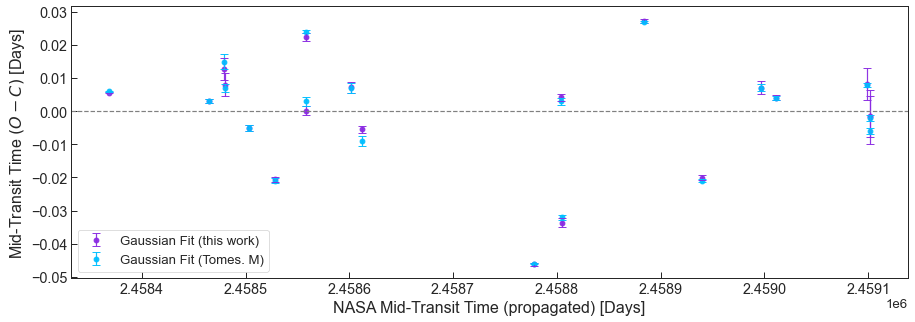

114
20


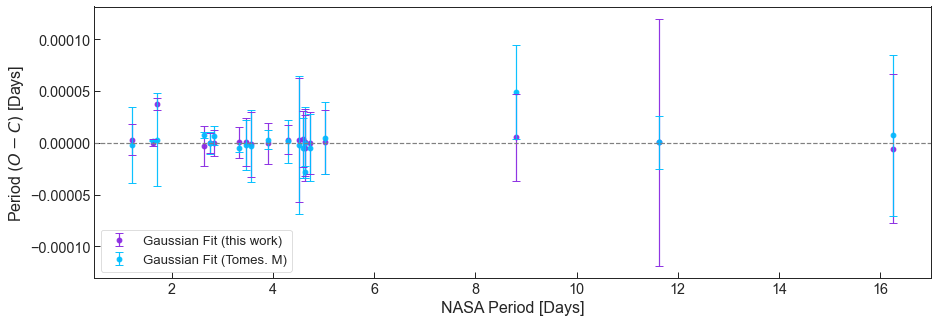

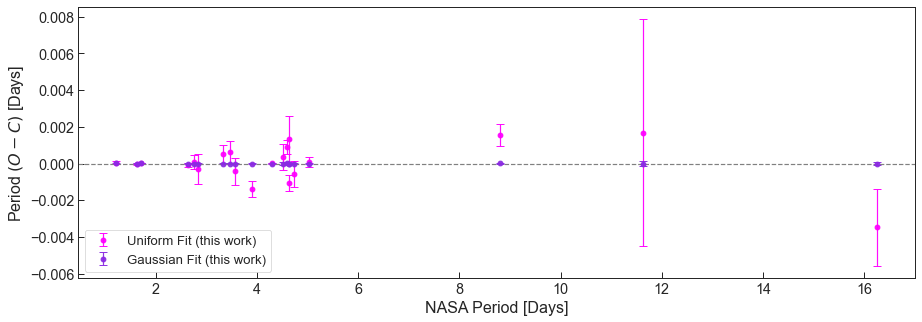

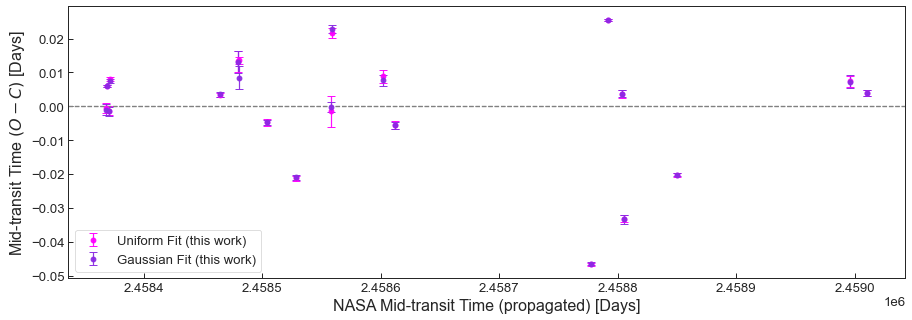

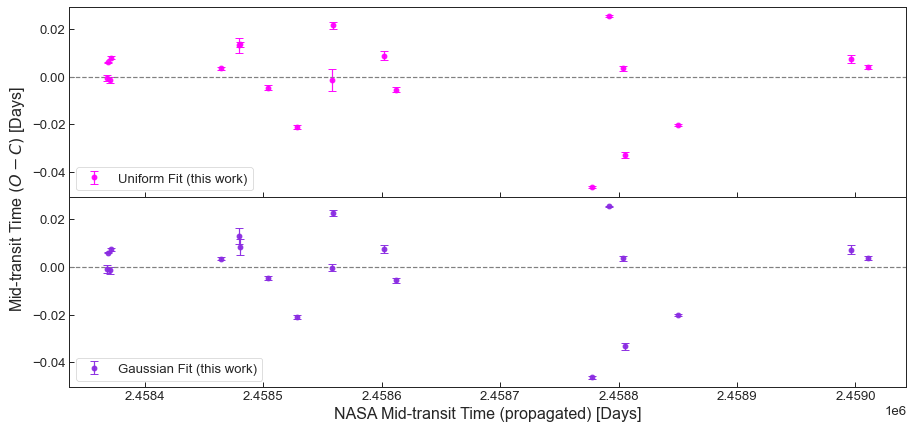

Errors for WASP-5 b are; 0.008928150000000001 and 0.0002081450074915
Errors for KELT-1 b are; 0.03753 and 0.000490351812914


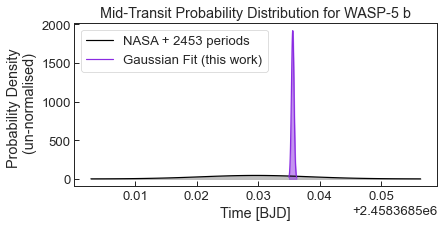

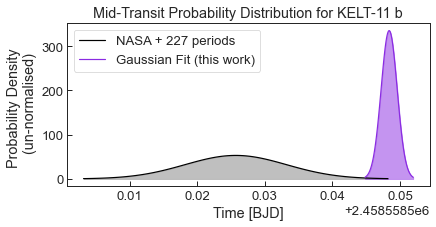

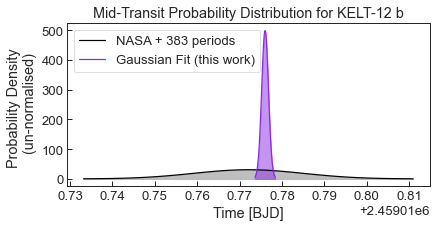

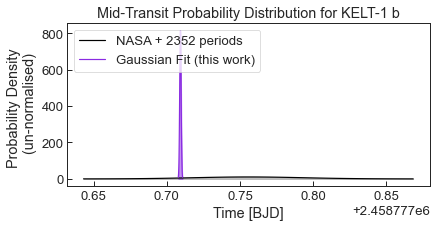

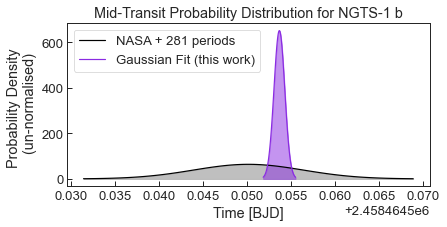

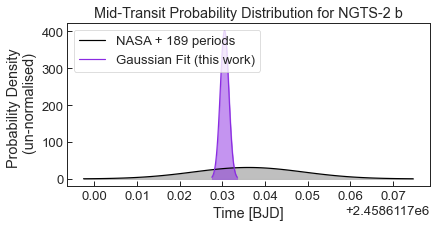

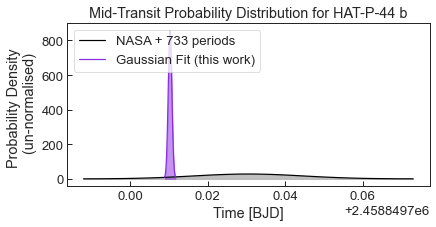

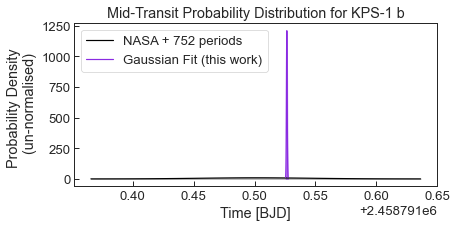

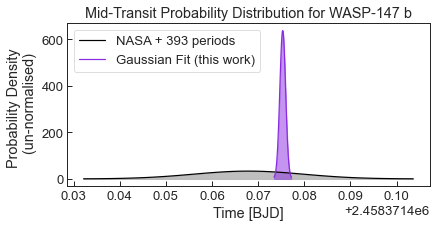

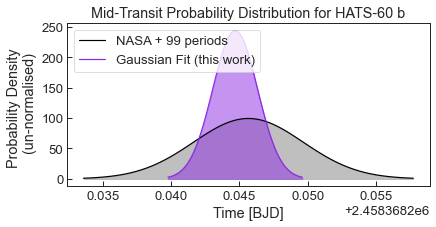

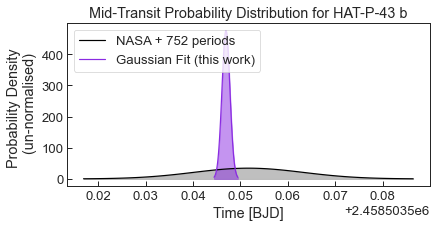

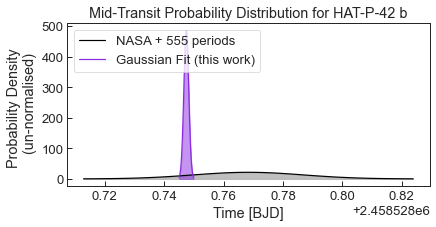

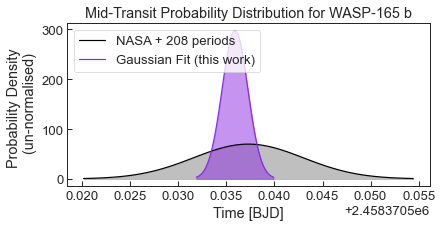

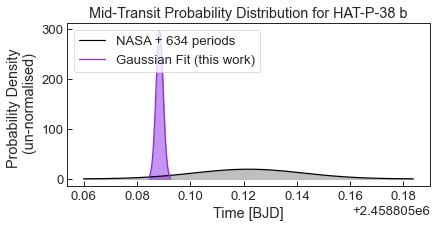

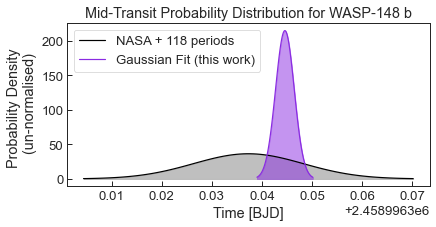

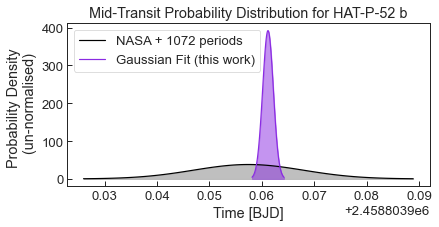

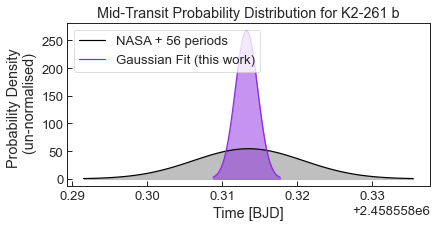

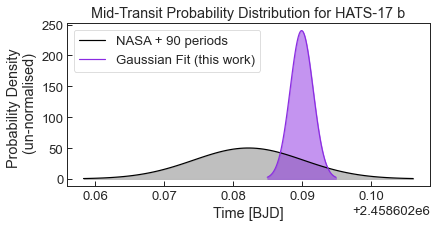

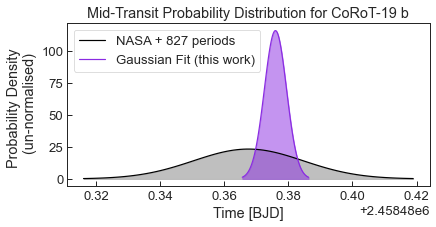

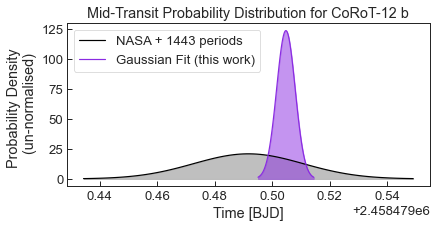

In [45]:
plt.figure(figsize=(15,5))
#plt.errorbar(np.array(P_N), np.array(P_DiffUN), yerr=np.array(P_UnifE), fmt='go' ,ecolor='green', alpha=1.0, label='Uniform Fit')
plt.errorbar(np.array(T0_Nas), np.array(T0_GausL)-np.array(T0_Nas), yerr=np.array(T0_GausLE), capsize=4, capthick=1, barsabove=True, linestyle='none', color='blueviolet', marker='o' ,ecolor='blueviolet', alpha=0.95, label='Gaussian Fit (this work)')
plt.errorbar(np.array(T0_Nas), np.array(T0_GausM)-np.array(T0_Nas), yerr=np.array(T0_GausME), capsize=4, capthick=1, barsabove=True, linestyle='none', color='deepskyblue', marker='o' ,ecolor='deepskyblue', alpha=0.95, label='Gaussian Fit (Tomes. M)')
plt.axhline(0, xmin=0, xmax=np.max(T0_Nas), color='gray', linestyle='dashed')
plt.ylabel(r'Mid-Transit Time $(O-C)$ [Days]', fontsize=16)
plt.xlabel(r'NASA Mid-Transit Time (propagated) [Days]', fontsize=16)
plt.tick_params(which='major', labelsize='x-large', length=6)
plt.tick_params(which='minor', labelsize='x-large', length=4)
plt.subplots_adjust(hspace=0)
plt.legend(loc='lower left')
plt.show()

print(len(Results))
i = 5

NAME = []
NUM = []
P_N = []
P_UnifE = []
P_DiffUN = []
P_GausE = []
P_DiffGN = []

T0_NASA = []
T0_NASAE = []
T0_Unif = []
T0_UnifE = []
T0_Gaus = []
T0_GausE = []

while i+4 <= len(Results)-10:
    NAME.append(Results['Name'][i])
    NUM.append(Results['Elapsed_Periods'][i+3])
    P_N.append(Results['Period'][i])
    P_NE = (0.5*(np.abs(Results['Period_LE'][i])+np.abs(Results['Period_UE'][i])))

    P_DiffUN.append(Results['Period'][i+2] - Results['Period'][i])
    P_DiffGN.append(Results['Period'][i+3] - Results['Period'][i])
    P_UnifE.append(0.5*(np.abs(Results['Period_LE'][i+2])+np.abs(Results['Period_UE'][i+2]))) 
    P_GausE.append(0.5*(np.abs(Results['Period_LE'][i+3])+np.abs(Results['Period_UE'][i+3]))) 
    
    T0_NASA.append(Results['Mid-transit time'][i] + ((Results['Elapsed_Periods'][i+3]) * (Results['Period'][i])))
    T0E = (0.5*(np.abs(Results['Mid-transit_LE'][i]) + np.abs(Results['Mid-transit_UE'][i])))
    T0_NASAE.append(T0E + (Results['Elapsed_Periods'][i+3]*P_NE))
    T0_Unif.append(Results['Mid-transit time'][i+2])
    T0_UnifE.append(0.5*(np.abs(Results['Mid-transit_LE'][i+2])+np.abs(Results['Mid-transit_UE'][i+2]))) 
    T0_Gaus.append(Results['Mid-transit time'][i+3])
    T0_GausE.append(0.5*(np.abs(Results['Mid-transit_LE'][i+3])+np.abs(Results['Mid-transit_UE'][i+3]))) 
    i+=5

print(len(P_N))

#----------------------------------------------------------------#

plt.figure(figsize=(15,5))
#plt.errorbar(np.array(P_N), np.array(P_DiffUN), yerr=np.array(P_UnifE), fmt='go' ,ecolor='green', alpha=1.0, label='Uniform Fit')
plt.errorbar(np.array(P_N), np.array(P_DiffGN), yerr=np.array(P_GausE), linestyle='none', color='blueviolet', marker='o' ,ecolor='blueviolet', alpha=0.95, capsize=4, capthick=1, barsabove=True, label='Gaussian Fit (this work)')
plt.errorbar(np.array(P_Nas), np.array(P_GausM)-np.array(P_Nas), yerr=np.array(P_GausME), linestyle='none', color='deepskyblue', marker='o' ,ecolor='deepskyblue', alpha=0.95, capsize=4, capthick=1, barsabove=True, label='Gaussian Fit (Tomes. M)')
plt.axhline(0, xmin=0, xmax=np.max(P_N), color='gray', linestyle='dashed')
plt.ylabel(r'Period $(O-C)$ [Days]', fontsize=16)
plt.xlabel(r'NASA Period [Days]', fontsize=16)
plt.tick_params(which='major', labelsize='x-large', length=6)
plt.tick_params(which='minor', labelsize='x-large', length=4)
plt.subplots_adjust(hspace=0)
plt.legend(loc='lower left')
plt.show()

#----------------------------------------------------------------#

plt.figure(figsize=(15,5))
plt.errorbar(np.array(P_N), np.array(P_DiffUN), yerr=np.array(P_UnifE), linestyle='none', color='fuchsia', marker='o' ,ecolor='fuchsia', capsize=4, capthick=1, alpha=0.95, label='Uniform Fit (this work)')
plt.errorbar(np.array(P_N), np.array(P_DiffGN), yerr=np.array(P_GausE), linestyle='none', color='blueviolet', marker='o' ,ecolor='blueviolet', alpha=0.95, capsize=4, capthick=1, label='Gaussian Fit (this work)')
#plt.errorbar(np.array(P_Nas), np.array(P_GausM)-np.array(P_Nas), yerr=np.array(P_GausE), fmt='ro' ,ecolor='gray', alpha=0.75, label='Gaussian Fit')
plt.axhline(0, xmin=0, xmax=np.max(P_N), color='gray', linestyle='dashed')
plt.ylabel(r'Period $(O-C)$ [Days]', fontsize=16)
plt.xlabel(r'NASA Period [Days]', fontsize=16)
plt.tick_params(which='major', labelsize='x-large', length=6)
plt.tick_params(which='minor', labelsize='x-large', length=4)
plt.subplots_adjust(hspace=0)
plt.legend(loc='lower left')
plt.show()

#----------------------------------------------------------------#

plt.figure(figsize=(15,5)) 
plt.errorbar(np.array(T0_NASA), (np.array(T0_Unif) - np.array(T0_NASA)), yerr=np.array(T0_UnifE), capsize=4, capthick=1, linestyle='none', color='fuchsia', marker='o' ,ecolor='fuchsia', alpha=0.95, label='Uniform Fit (this work)')
plt.axhline(0, xmin=0, xmax=np.max(T0_NASA), color='gray', linestyle='dashed')
plt.errorbar(np.array(T0_NASA), (np.array(T0_Gaus) - np.array(T0_NASA)), yerr=np.array(T0_GausE), capsize=4, capthick=1, linestyle='none', color='blueviolet', marker='o' ,ecolor='blueviolet', alpha=0.95, label='Gaussian Fit (this work)')
plt.axhline(0, xmin=0, xmax=np.max(T0_NASA), color='gray', linestyle='dashed')
#ax[2].errorbar(np.array(T0_Nas), (np.array(T0_GausM) - np.array(T0_Nas)), yerr=np.array(T0_GausME), fmt='ro' ,ecolor='red', capsize=4, alpha=0.75, label='Gaussian Fit (Maddie)')
#ax[2].axhline(0, xmin=0, xmax=np.max(T0_Nas), color='gray', linestyle='dashed')

#ax[0].set_ylabel(r'Mid-transit Time $(O-C)$ [Days]', fontsize=16)
plt.legend(loc='lower left')
#ax[1].set_ylabel(r'Mid-transit Time $(O-C)$ [Days]', fontsize=16)
#ax[1].legend(loc='lower left')
#ax[2].legend(loc='lower left')
plt.xlabel(r'NASA Mid-transit Time (propagated) [Days]', fontsize=16)
plt.ylabel(r'Mid-transit Time $(O-C)$ [Days]', fontsize=16)
#plt.tick_params(which='major', labelsize='x-large', length=6)
#plt.tick_params(which='minor', labelsize='x-large', length=4)
#fig.text(0.0675, 0.5, r'Mid-transit Time $(O-C)$ [Days]', va='center', rotation='vertical', fontsize=16)
plt.subplots_adjust(hspace=0)
plt.show()

fig, ax = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(15,7)) 
ax[0].errorbar(np.array(T0_NASA), (np.array(T0_Unif) - np.array(T0_NASA)), yerr=np.array(T0_UnifE), capsize=4, capthick=1, linestyle='none', color='fuchsia', marker='o' ,ecolor='fuchsia', alpha=0.95, label='Uniform Fit (this work)')
ax[0].axhline(0, xmin=0, xmax=np.max(T0_NASA), color='gray', linestyle='dashed')
ax[1].errorbar(np.array(T0_NASA), (np.array(T0_Gaus) - np.array(T0_NASA)), yerr=np.array(T0_GausE), capsize=4, capthick=1, linestyle='none', color='blueviolet', marker='o' ,ecolor='blueviolet', alpha=0.95, label='Gaussian Fit (this work)')
ax[1].axhline(0, xmin=0, xmax=np.max(T0_NASA), color='gray', linestyle='dashed')
#ax[2].errorbar(np.array(T0_Nas), (np.array(T0_GausM) - np.array(T0_Nas)), yerr=np.array(T0_GausME), fmt='ro' ,ecolor='red', capsize=4, alpha=0.75, label='Gaussian Fit (Tomes. M)')
#ax[2].axhline(0, xmin=0, xmax=np.max(T0_Nas), color='gray', linestyle='dashed')

#ax[0].set_ylabel(r'Mid-transit Time $(O-C)$ [Days]', fontsize=16)
ax[0].legend(loc='lower left')
#ax[1].set_ylabel(r'Mid-transit Time $(O-C)$ [Days]', fontsize=16)
ax[1].legend(loc='lower left')
#ax[2].legend(loc='lower left')
ax[1].set_xlabel(r'NASA Mid-transit Time (propagated) [Days]', fontsize=16)
#plt.tick_params(which='major', labelsize='x-large', length=6)
#plt.tick_params(which='minor', labelsize='x-large', length=4)
fig.text(0.0675, 0.5, r'Mid-transit Time $(O-C)$ [Days]', va='center', rotation='vertical', fontsize=16)
plt.subplots_adjust(hspace=0)
plt.show()

print(f'Errors for {NAME[0]} are;', T0_NASAE[0], 'and', T0_GausE[0])
print(f'Errors for {NAME[3]} are;', T0_NASAE[3], 'and', T0_GausE[3])

for i in range(0, len(T0_NASA)):
    Name = NAME[i]
    Number = NUM[i]
    T0n = T0_NASA[i]
    T0ne = T0_NASAE[i]
    N = np.linspace((T0n - 3*T0ne), (T0n + 3*T0ne), 100) #TIME ARRAYS
    #print(N)
    T0f = T0_Gaus[i]
    T0fe = T0_GausE[i]
    F = np.linspace((T0f - 3*T0fe), (T0f + 3*T0fe), 100) #TIME ARRAYS
    #print(F)
    plt.figure(figsize=(6.5, 3))
    plt.plot(N, (stats.norm.pdf(N, T0n, T0ne)), color='black', label=f'NASA + {np.int(Number)} periods')
    plt.fill_between(N, (stats.norm.pdf(N, T0n, T0ne)), color='gray', alpha=0.5)
    plt.plot(F, (stats.norm.pdf(F, T0f, T0fe)), color='blueviolet', label='Gaussian Fit (this work)')
    plt.fill_between(F, (stats.norm.pdf(F, T0f, T0fe)), color='blueviolet', alpha=0.5)
    plt.xlabel('Time [BJD]')
    plt.ylabel('Probability Density \n (un-normalised)')
    plt.title(f'Mid-Transit Probability Distribution for {Name}')
    plt.legend(loc='upper left')
    plt.show()

In [23]:
#today = date(2021, 11, 30) # 1month after JWST launch
today = date(2025, 1, 1)   # 1st Jan 2025
now = today.strftime("%Y-%m-%d %H:%M:%S")
jd_today = Time(now, format='iso', scale='utc').jd
print(jd_today)


NAME = []
NUM = []
P_Gaus = []
P_GausE = []
#P_DiffGN = []

T0_Gaus = []
T0_GausE = []

Diff = []
DiffUP = []

i=0
while i+4 <= len(Results)-10:
    NAME.append(Results['Name'][i])
    NUM.append(Results['Elapsed_Periods'][i+3])
    # Gaussian fitted period and avg uncertainty
    P_Gaus.append(Results['Period'][i+3])
    P_GausE.append(0.5*(np.abs(Results['Period_LE'][i+3])+np.abs(Results['Period_UE'][i+3]))) 
    
    T0_Gaus.append(Results['Mid-transit time'][i+3])
    T0_GausE.append(0.5*(np.abs(Results['Mid-transit_LE'][i+3])+np.abs(Results['Mid-transit_UE'][i+3]))) 
    
    Diff.append( (jd_today - Results['Mid-transit time'][i+3]) / Results['Period'][i+3] )
    DiffUP.append( math.ceil((jd_today - Results['Mid-transit time'][i+3]) / Results['Period'][i+3]) )
    
    i+=5
    
print(Diff)
print(DiffUP)

JWST_E = (np.array(T0_GausE) + np.array(DiffUP) * np.array(P_GausE))*24*60
print(JWST_E)

2460676.5
[787.7088366157398, 1417.2959925098965, 447.1932042806294, 331.05097797715524, 1559.5596902876553, 835.5495171376654, 457.70188123637826, 424.7141310252911, 1104.695241607837, 500.7946734128516, 648.2356310289587, 652.0122633932493, 462.6909788245088, 665.403992864568, 403.28822661795925, 190.84401373753562, 680.0341418804502, 182.0774156726112, 127.61983640573537, 563.5235008285196, 776.8609326272525]
[788, 1418, 448, 332, 1560, 836, 458, 425, 1105, 501, 649, 653, 463, 666, 404, 191, 681, 183, 128, 564, 777]
[ 1.77484488  7.49114048 20.98918798 15.93890512 33.73792477 24.29109864
 41.13578132  9.21709381  9.77810653 20.31526512 31.97563062 15.35401311
 22.42289499 24.00797935 20.67398173 14.2306632  10.63523187 33.62241575
 15.67857915 21.0809453  19.07645167]


In [ ]:
JWST [Days]
0.0006325  0.00276151 0.00746399 0.00410989 0.0098129  0.00858537
0.01351497 0.00274189 0.00292584 0.00751457 0.01215891 0.0055625
0.00783059 0.00916721 0.00653126 0.00450647 0.00355167 0.01176244
0.00591362 0.00890473 0.00810487

JWST [minutes]
0.9107956   3.97657892 10.74814519  5.91823999 14.1305763  12.3629356
19.46155306  3.9483155   4.21320623 10.82098528 17.50883732  8.01000558
11.27605622 13.20077888  9.40502029  6.48932304  5.1144104  16.93791524
8.51561297 12.82281181 11.6710083

ELT / EXCITE [Days]
0.00123253 0.00520218 0.01457582 0.01106868 0.02342911 0.01686882
0.02856651 0.00640076 0.00679035 0.01410782 0.0222053  0.01066251
0.01557145 0.01667221 0.01435693 0.0098824  0.00738558 0.0233489
0.0108879  0.01463955 0.01324754

ELT / EXCITE [minutes]
1.77484488  7.49114048 20.98918798 15.93890512 33.73792477 24.29109864
41.13578132  9.21709381  9.77810653 20.31526512 31.97563062 15.35401311
22.42289499 24.00797935 20.67398173 14.2306632  10.63523187 33.62241575
15.67857915 21.0809453  19.07645167